In [1]:
%load_ext autoreload
%autoreload 2
import sys
# sys.path.append("D:/Github/note/module")                        # for windows
sys.path.append("/Users/xinc./Documents/GitHub/note/module")    # for mac
from get_info_FinMind import GetInfoFinMind
import pandas as pd
import numpy as np
from pprint import pprint
from typing import Any
from scipy.stats import linregress, ttest_1samp
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# function

## plot

In [2]:
def plot(
        df: pd.DataFrame,
        ly: str,                              # 左邊 y 軸欄位
        x: str = "index",                     # x 軸欄位名稱
        ry: str | None = None,                # 右邊 y 軸欄位
        max_ly: bool = False,                 # 左邊是否標記 y 最大值
        min_ly: bool = False,                 # 左邊是否標記 y 最小值
        max_ry: bool = False,                 # 右邊是否標記 y 最大值
        min_ry: bool = False,                 # 右邊是否標記 y 最小值
        point_ly: float | None = None,        # 左邊要標記的 y 值
        point_ry: float | None = None,        # 右邊要標記的 y 值
        point_pct_ly: float | None = None,    # 依百分比標記左邊 y 值
        point_pct_ry: float | None = None     # 依百分比標記右邊 y 值
):
    if len(df) == 0:
        return {}

    # 決定 x 軸
    if x == "index":
        # 判斷 index 是否為 DatetimeIndex
        if isinstance(df.index, pd.DatetimeIndex):
            x_vals = pd.Series(df.index, index = df.index, name = "x")
            x_label = "Time"
        else:
            # 若不是時間，就使用 sample proportion
            x_vals = pd.Series(
                np.arange(len(df), dtype = float) / max(len(df), 1),
                index = df.index,
                name = "x"
            )
            x_label = "sample proportion"
    else:
        x_vals = pd.Series(df[x], index = df.index, name = x)
        x_label = x

    left_y = df[ly].astype(float)

    fig = make_subplots(specs = [[{"secondary_y": bool(ry)}]])
    fig.add_trace(
        go.Scatter(
            x = x_vals,
            y = left_y,
            mode = "lines",
            name = ly,
            line = dict(color = "rgb(31, 119, 180)"),
        ),
        secondary_y = False,
    )

    fig.update_layout(
        template = "plotly_white",
        height = 500,
        legend = dict(x = 1.02, y = 0.5, xanchor = "left"),
        margin = dict(t = 50, r = 160, b = 50, l = 70),
    )
    fig.update_xaxes(title_text = x_label, showgrid = True)
    fig.update_yaxes(
        title = dict(text = ly, font = dict(color = "rgb(31, 119, 180)")),
        secondary_y = False,
        showgrid = True,
        tickfont = dict(color = "rgb(31, 119, 180)"),
    )

    def _to_numeric(value: Any) -> float | None:
        try:
            arr = np.asarray(value)
            if arr.shape == ():
                arr = np.asarray([value])
            if np.issubdtype(arr.dtype, np.number):
                return float(value)
        except (TypeError, ValueError):
            pass
        return None

    def _y_pad(series: pd.Series) -> float:
        if len(series) == 0:
            return 1.0
        arr = np.abs(series.to_numpy(dtype = float))
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            return 1.0
        pad = arr.max() * 0.05
        return pad if pad else 1.0

    y_pad_left = _y_pad(left_y)

    mark: dict[str, Any] = {
        "max_ly": None,
        "min_ly": None,
        "max_ry": None,
        "min_ry": None,
        "point_ly": None,
        "point_ry": None
    }

    # 標記 max ly
    if max_ly and len(left_y) > 0:
        max_pos = int(np.argmax(left_y))
        max_idx = left_y.index[max_pos]
        max_x = x_vals.loc[max_idx]
        max_y = left_y.iloc[max_pos]
        numeric_x = _to_numeric(max_x)
        percent = numeric_x * 100 if numeric_x is not None else np.nan

        fig.add_trace(
            go.Scatter(
                x = [max_x],
                y = [max_y],
                mode = "markers",
                marker = dict(color = "black", size = 8),
                showlegend = False,
                name = f"{ly} max",
            ),
            secondary_y = False,
        )
        fig.add_vline(x = max_x, line_color = "gray", line_dash = "dash", row = 1, col = 1)
        text = f"{ly} max\nidx = {max_idx}\ny = {max_y:.4f}"
        if np.isfinite(percent):
            text += f"\n({percent:.1f} %)"
        fig.add_annotation(
            x = max_x,
            y = max_y + y_pad_left,
            text = text,
            showarrow = False,
            font = dict(color = "black"),
            xanchor = "center",
            yref = "y",
        )
        mark["max_ly"] = {
            "index": max_idx,
            "rank": max_pos + 1,
            "proportion": float(max_pos / len(left_y)),
            "x": numeric_x,
            "y": float(max_y)
        }

    # 標記 min ly
    if min_ly and len(left_y) > 0:
        min_pos = int(np.argmin(left_y))
        min_idx = left_y.index[min_pos]
        min_x = x_vals.loc[min_idx]
        min_y = left_y.iloc[min_pos]
        numeric_x = _to_numeric(min_x)
        percent = numeric_x * 100 if numeric_x is not None else np.nan

        fig.add_trace(
            go.Scatter(
                x = [min_x],
                y = [min_y],
                mode = "markers",
                marker = dict(color = "black", size = 8),
                showlegend = False,
                name = f"{ly} min",
            ),
            secondary_y = False,
        )
        fig.add_vline(x = min_x, line_color = "gray", line_dash = "dash", row = 1, col = 1)
        text = f"{ly} min\nidx = {min_idx}\ny = {min_y:.4f}"
        if np.isfinite(percent):
            text += f"\n({percent:.1f} %)"
        fig.add_annotation(
            x = min_x,
            y = min_y - y_pad_left,
            text = text,
            showarrow = False,
            font = dict(color = "black"),
            xanchor = "center",
            yanchor = "top",
            yref = "y",
        )
        mark["min_ly"] = {
            "index": min_idx,
            "rank": min_pos + 1,
            "proportion": float(min_pos / len(left_y)),
            "x": numeric_x,
            "y": float(min_y)
        }

    # 標記指定的 left y
    if point_ly is not None or point_pct_ly is not None:
        if isinstance(point_ly, str):
            if point_ly.lower() == "max":
                pos = int(np.argmax(left_y))
            elif point_ly.lower() == "min":
                pos = int(np.argmin(left_y))
            else:
                raise ValueError("point_ly must be a number or 'max' or 'min'")
        elif point_pct_ly is not None:
            pct = float(point_pct_ly)
            if pct > 1:
                pct /= 100
            pct = min(max(pct, 0.0), 1.0)
            pos = int(round(pct * (len(df) - 1)))
        else:
            assert point_ly is not None
            diff_arr = (left_y - float(point_ly)).abs().to_numpy()
            pos = int(np.argmin(diff_arr))

        idx_ly = left_y.index[pos]
        px = x_vals.loc[idx_ly]
        py = left_y.iloc[pos]
        percent = float(pos / len(left_y) * 100.0)

        fig.add_trace(
            go.Scatter(
                x = [px],
                y = [py],
                mode = "markers",
                marker = dict(color = "black", size = 8),
                showlegend = False,
                name = f"{ly} point",
            ),
            secondary_y = False,
        )
        fig.add_vline(x = px, line_color = "black", line_dash = "dash", row = 1, col = 1)
        fig.add_annotation(
            x = px,
            y = py + y_pad_left,
            text = f"{ly}\nidx = {idx_ly}\ny = {py:.4f}\n( {percent:.1f}  %)",
            showarrow = False,
            font = dict(color = "black"),
            xanchor = "center",
            yref = "y",
        )
        mark["point_ly"] = {
            "index": idx_ly,
            "rank": pos + 1,
            "proportion": float(pos / len(left_y)),
            "x": _to_numeric(px),
            "y": float(py)
        }

    # 設定右側 y 軸
    if ry:
        right_y = df[ry].astype(float)
        fig.add_trace(
            go.Scatter(
                x = x_vals,
                y = right_y,
                mode = "lines",
                name = ry,
                line = dict(color = "rgb(214, 39, 40)", dash = "dash"),
            ),
            secondary_y = True,
        )
        fig.update_yaxes(
            title = dict(text = ry, font = dict(color = "rgb(214, 39, 40)")),
            secondary_y = True,
            showgrid = False,
            tickfont = dict(color = "rgb(214, 39, 40)"),
        )

        y_pad_right = _y_pad(right_y)

        if max_ry and len(right_y) > 0:
            max_pos = int(np.argmax(right_y))
            max_idx = right_y.index[max_pos]
            max_x = x_vals.loc[max_idx]
            max_y = right_y.iloc[max_pos]
            numeric_x = _to_numeric(max_x)
            percent = numeric_x * 100 if numeric_x is not None else np.nan

            fig.add_trace(
                go.Scatter(
                    x = [max_x],
                    y = [max_y],
                    mode = "markers",
                    marker = dict(color = "black", size = 8),
                    showlegend = False,
                    name = f"{ry} max",
                ),
                secondary_y = True,
            )
            fig.add_vline(x = max_x, line_color = "gray", line_dash = "dash", row = 1, col = 1)
            text = f"{ry} max\nidx = {max_idx}\ny = {max_y:.4f}"
            if np.isfinite(percent):
                text += f"\n{percent:.1f} %"
            fig.add_annotation(
                x = max_x,
                y = max_y + y_pad_right,
                text = text,
                showarrow = False,
                font = dict(color = "black"),
                xanchor = "center",
                yref = "y2",
            )
            mark["max_ry"] = {
                "index": max_idx,
                "rank": max_pos + 1,
                "proportion": float(max_pos / len(right_y)),
                "x": numeric_x,
                "y": float(max_y)
            }

        if min_ry and len(right_y) > 0:
            min_pos = int(np.argmin(right_y))
            min_idx = right_y.index[min_pos]
            min_x = x_vals.loc[min_idx]
            min_y = right_y.iloc[min_pos]
            numeric_x = _to_numeric(min_x)
            percent = numeric_x * 100 if numeric_x is not None else np.nan

            fig.add_trace(
                go.Scatter(
                    x = [min_x],
                    y = [min_y],
                    mode = "markers",
                    marker = dict(color = "black", size = 8),
                    showlegend = False,
                    name = f"{ry} min",
                ),
                secondary_y = True,
            )
            fig.add_vline(x = min_x, line_color = "gray", line_dash = "dash", row = 1, col = 1)
            text = f"{ry} min\nidx = {min_idx}\ny = {min_y:.4f}"
            if np.isfinite(percent):
                text += f"\n({percent:.1f} %)"
            fig.add_annotation(
                x = min_x,
                y = min_y - y_pad_right,
                text = text,
                showarrow = False,
                font = dict(color = "black"),
                xanchor = "center",
                yanchor = "top",
                yref = "y2",
            )
            mark["min_ry"] = {
                "index": min_idx,
                "rank": min_pos + 1,
                "proportion": float(min_pos / len(right_y)),
                "x": numeric_x,
                "y": float(min_y)
            }

        if point_ry is not None or point_pct_ry is not None:
            if point_ry is None and point_pct_ry is not None:
                pct = float(point_pct_ry)
                if pct > 1:
                    pct /= 100
                pct = min(max(pct, 0.0), 1.0)
                pos = int(round(pct * (len(df) - 1)))
            elif isinstance(point_ry, str):
                if point_ry.lower() == "max":
                    pos = int(np.argmax(right_y))
                elif point_ry.lower() == "min":
                    pos = int(np.argmin(right_y))
                else:
                    raise ValueError("point_ry must be a number or 'max' or 'min'")
            elif point_pct_ry is not None:
                pct = float(point_pct_ry)
                if pct > 1:
                    pct /= 100
                pct = min(max(pct, 0.0), 1.0)
                pos = int(round(pct * (len(df) - 1)))
            else:
                assert point_ry is not None
                diff_arr = (right_y - float(point_ry)).abs().to_numpy()
                pos = int(np.argmin(diff_arr))

            idx_ry = right_y.index[pos]
            px = x_vals.loc[idx_ry]
            py = right_y.iloc[pos]
            percent = float(pos / len(right_y) * 100.0)

            fig.add_trace(
                go.Scatter(
                    x = [px],
                    y = [py],
                    mode = "markers",
                    marker = dict(color = "black", size = 8),
                    showlegend = False,
                    name = f"{ry} point",
                ),
                secondary_y = True,
            )
            fig.add_vline(x = px, line_color = "black", line_dash = "dash", row = 1, col = 1)
            fig.add_annotation(
                x = px,
                y = py + y_pad_right,
                text = f"{ry}\nidx = {idx_ry}\ny = {py}\n({percent:.1f} %)",
                showarrow = False,
                font = dict(color = "black"),
                xanchor = "center",
                yref = "y2",
            )
            mark["point_ry"] = {
                "index": idx_ry,
                "rank": pos + 1,
                "proportion": float(pos / len(right_y)),
                "x": _to_numeric(px),
                "y": float(py)
            }

    fig.add_annotation(
        text = f"Sample size: {len(df)}",
        x = 0.99,
        y = 0.02,
        xref = "paper",
        yref = "paper",
        showarrow = False,
        font = dict(color = "gray", size = 12),
        xanchor = "right",
    )

    fig.show()

    return mark

In [3]:
def plot_scatter(
        df: pd.DataFrame,
        x_col: str,
        y_col: str,
        title: str | None = None,
        marker_kwargs: dict | None = None,
        trendline_kwargs: dict | None = None,
):
    """Plot a scatter chart for two columns with a regression trend and summary statistics."""
    data = df[[x_col, y_col]].dropna()
    if len(data) < 2:
        raise ValueError("Need at least two non-null observations to plot scatter with stats.")

    x = data[x_col].astype(float)
    y = data[y_col].astype(float)

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    r_squared = r_value ** 2

    x_mean = x.mean()
    y_mean = y.mean()
    x_std = x.std(ddof = 1)
    y_std = y.std(ddof = 1)

    base_marker = dict(size = 8, opacity = 0.7, color = "rgba(31, 119, 180, 0.75)")
    if marker_kwargs:
        base_marker.update(marker_kwargs)

    trend_marker = dict(color = "rgba(214, 39, 40, 0.8)", width = 2)
    if trendline_kwargs:
        trend_marker.update(trendline_kwargs)

    line_x = np.linspace(x.min(), x.max(), 100)
    line_y = slope * line_x + intercept

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x = x,
            y = y,
            mode = "markers",
            marker = base_marker,
            name = f"{y_col} vs {x_col}",
            hovertemplate = f"{x_col}: %{{x}}<br>{y_col}: %{{y}}<extra></extra>",
        )
    )

    fig.add_trace(
        go.Scatter(
            x = line_x,
            y = line_y,
            mode = "lines",
            line = trend_marker,
            name = "Trendline",
            hoverinfo = "skip",
        )
    )

    fig.update_layout(
        template = "plotly_white",
        height = 520,
        title = title or f"Scatter of {y_col} vs {x_col}",
        legend = dict(x = 0.02, y = 0.98, xanchor = "left"),
        margin = dict(t = 60, r = 200, b = 60, l = 70),
    )

    fig.update_xaxes(title_text = x_col, showgrid = True)
    fig.update_yaxes(title_text = y_col, showgrid = True)

    fig.add_shape(
        type = "line",
        xref = "x",
        yref = "y",
        x0 = x_mean,
        x1 = x_mean,
        y0 = y.min(),
        y1 = y.max(),
        line = dict(color = "rgba(127, 127, 127, 0.7)", dash = "dash"),
        name = "x mean",
    )
    fig.add_shape(
        type = "line",
        xref = "x",
        yref = "y",
        x0 = x.min(),
        x1 = x.max(),
        y0 = y_mean,
        y1 = y_mean,
        line = dict(color = "rgba(127, 127, 127, 0.7)", dash = "dash"),
        name = "y mean",
    )

    stats_text = (
        f"n = {len(data)}"        f"<br>slope = {slope:.4f}"        f"<br>intercept = {intercept:.4f}"        f"<br>r = {r_value:.4f} (r² = {r_squared:.4f})"        f"<br>p-value = {p_value:.4g}"        f"<br>{x_col} mean ± std = {x_mean:.4f} ± {x_std:.4f}"        f"<br>{y_col} mean ± std = {y_mean:.4f} ± {y_std:.4f}"
    )

    fig.add_annotation(
        xref = "paper",
        yref = "paper",
        x = 1.02,
        y = 0.98,
        align = "left",
        showarrow = False,
        text = stats_text,
        bordercolor = "rgba(0, 0, 0, 0.2)",
        borderwidth = 1,
        borderpad = 6,
        bgcolor = "rgba(255, 255, 255, 0.8)",
    )

    fig.show()


In [4]:
def plot_df_columns(df, cols = None, title = None, xaxis_title = "Index", yaxis_title = "Value", template = "plotly_white"):
    """Render interactive Plotly line charts for the selected DataFrame columns."""
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame.")

    data = df if cols is None else df[cols]

    fig = go.Figure()
    for col in data.columns:
        fig.add_trace(
            go.Scatter(
                x = data.index,
                y = data[col],
                mode = "lines",
                name = str(col),
            )
        )

    fig.update_layout(
        title = title or ", ".join(map(str, data.columns)),
        xaxis_title = xaxis_title,
        yaxis_title = yaxis_title,
        template = template,
    )

    fig.show()

In [5]:
def plot_pdf(
    df: pd.DataFrame,
    col: str,
    title: str | None = None,
    figsize: tuple | None = None,
    color: str = "steelblue",
    bins: int = 50,
    show_hist: bool = False
) -> None:
    """Plot the PDF (kernel density) of a column with optional histogram."""
    data = df[col].dropna()
    if data.empty:
        raise ValueError(f"Column {col} has no data to plot.")

    mean_val = float(data.mean())
    median_val = float(data.median())

    # Silverman bandwidth for Gaussian KDE
    std = float(data.std(ddof = 1))
    n = len(data)
    bandwidth = 1.06 * std * (n ** (-1 / 5)) if std > 0 and n > 1 else 1.0

    sample_min, sample_max = data.min(), data.max()
    if sample_min == sample_max:
        sample_min -= 1e-6
        sample_max += 1e-6

    x_vals = np.linspace(sample_min, sample_max, 200)
    diffs = (x_vals[:, None] - data.to_numpy()[None, :]) / bandwidth
    kernel = np.exp(-0.5 * diffs ** 2)
    pdf = kernel.sum(axis = 1) / (n * bandwidth * np.sqrt(2 * np.pi))

    fig = go.Figure()

    if show_hist:
        fig.add_trace(
            go.Histogram(
                x = data,
                nbinsx = bins,
                histnorm = "probability density",
                marker = dict(color = color, opacity = 0.3),
                name = "Histogram"
            )
        )

    fig.add_trace(
        go.Scatter(
            x = x_vals,
            y = pdf,
            mode = "lines",
            line = dict(color = color, width = 2),
            name = "PDF"
        )
    )

    fig.add_vline(x = mean_val, line_dash = "dash", line_color = "orange", annotation_text = f"Mean = {mean_val:.4f}", annotation_position = "top right")
    fig.add_vline(x = median_val, line_dash = "dash", line_color = "gray", annotation_text = f"Median = {median_val:.4f}", annotation_position = "top left")

    layout_kwargs = dict(
        template = "plotly_white",
        title = title or f"PDF of {col}",
        xaxis_title = col,
        yaxis_title = "Density",
        bargap = 0.05,
        legend = dict(orientation = "h", yanchor = "bottom", y = 1.02, xanchor = "right", x = 1)
    )
    if figsize:
        layout_kwargs["height"] = int(figsize[1] * 60)
        layout_kwargs["width"] = int(figsize[0] * 60)
    fig.update_layout(**layout_kwargs)

    fig.update_xaxes(showgrid = True)
    fig.update_yaxes(showgrid = True)

    fig.show()


In [6]:
# Visualize expected positions of dropped groups when sorting by indicator
def plot_dropped_positions(full_df: pd.DataFrame, dropped_df: pd.DataFrame, group_col: str = "weekly_group", sort_col: str = "indicator") -> None:
    if group_col not in full_df.columns or group_col not in dropped_df.columns:
        raise KeyError(f"{group_col} must exist in both dataframes")
    if sort_col not in dropped_df.columns and sort_col not in full_df.columns:
        raise KeyError(f"{sort_col} not found in either dataframe")

    def summarize_indicator(series: pd.Series) -> float:
        cleaned = series.dropna()
        return float(cleaned.iloc[0]) if not cleaned.empty else float("nan")

    kept_groups = (
        dropped_df.groupby(group_col, sort=False)[sort_col]
        .apply(summarize_indicator)
        .reset_index(name=sort_col)
    )
    kept_groups["status"] = "kept"

    dropped_group_keys = set(full_df[group_col]) - set(dropped_df[group_col])
    dropped_rows = full_df[full_df[group_col].isin(dropped_group_keys)]
    if dropped_rows.empty:
        print("No dropped groups detected.")
        return

    dropped_groups = (
        dropped_rows.groupby(group_col, sort=False)[sort_col]
        .apply(summarize_indicator)
        .reset_index(name=sort_col)
    )
    dropped_groups["status"] = "dropped"

    all_groups = pd.concat([kept_groups, dropped_groups], ignore_index=True)
    known = all_groups[all_groups[sort_col].notna()].copy()
    unknown = all_groups[all_groups[sort_col].isna()].copy()

    known.sort_values(sort_col, inplace=True)
    known.reset_index(drop=True, inplace=True)
    known["x_rank"] = known.index

    plot_df = known
    if not unknown.empty:
        unknown = unknown.reset_index(drop=True)
        unknown["x_rank"] = range(len(plot_df), len(plot_df) + len(unknown))
        plot_df = pd.concat([plot_df, unknown], ignore_index=True)

    fig = go.Figure()
    colors = {"kept": "#1f77b4", "dropped": "#d62728"}
    for status, color in colors.items():
        subset = plot_df[plot_df["status"] == status]
        if subset.empty:
            continue
        fig.add_trace(
            go.Scatter(
                x=subset["x_rank"],
                y=[1] * len(subset),
                mode="markers",
                marker=dict(size=8, color=color),
                name=status.capitalize(),
                hovertemplate=(f"{group_col}: %{{customdata[0]}}<br>{sort_col}: %{{customdata[1]}}<extra></extra>"),
                customdata=subset[[group_col, sort_col]].to_numpy()
            )
        )

    fig.update_layout(
        template="plotly_white",
        title=f"Group positions when sorted by {sort_col}",
        xaxis=dict(title="Rank in sorted order"),
        yaxis=dict(visible=False),
        height=320
    )
    fig.show()


In [8]:
def plot_sequence(
        df: pd.DataFrame,
        col: str,
        x_col: str | None = None,
        title: str | None = None,
        template: str = "plotly_white",
        positive_color: str = "rgba(44, 160, 44, 0.75)",
        negative_color: str = "rgba(214, 39, 40, 0.75)",
        show_zero_line: bool = True,
):
    """Plot a bar chart of returns in original order with positives up and negatives down."""
    if col not in df:
        raise KeyError(f"Column '{col}' not found in DataFrame.")
    if x_col is not None and x_col not in df:
        raise KeyError(f"Column '{x_col}' not found in DataFrame.")

    series = df[col].dropna().astype(float)
    if len(series) == 0:
        raise ValueError("No non-null values to plot.")

    aligned_df = df.loc[series.index]
    if x_col is None:
        x_vals = aligned_df.index
    else:
        x_vals = aligned_df[x_col]

    colors = np.where(series >= 0, positive_color, negative_color).tolist()

    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x = x_vals,
            y = series,
            marker = dict(color = colors, line = dict(color = "rgba(0, 0, 0, 0.2)", width = 0.5)),
            hovertemplate = "%{x}<br>return: %{y:.6f}<extra></extra>",
            name = col,
        )
    )

    fig.update_layout(
        template = template,
        title = title or f"Return sequence for {col}",
        xaxis_title = x_col or "Index",
        yaxis_title = col,
        bargap = 0,
        margin = dict(t = 60, r = 200, b = 60, l = 70),
    )

    if show_zero_line:
        fig.add_shape(
            type = "line",
            xref = "paper",
            yref = "y",
            x0 = 0,
            x1 = 1,
            y0 = 0,
            y1 = 0,
            line = dict(color = "rgba(99, 110, 250, 0.6)", dash = "dash"),
        )

    mean = series.mean()
    std = series.std(ddof = 1)
    max_val = series.max()
    min_val = series.min()

    stats_text = (
        f"n = {len(series)}"        f"<br>mean = {mean:.6f}"        f"<br>std = {std:.6f}"        f"<br>max = {max_val:.6f}"        f"<br>min = {min_val:.6f}"
    )
    fig.add_annotation(
        xref = "paper",
        yref = "paper",
        x = 1.02,
        y = 0.98,
        showarrow = False,
        align = "left",
        text = stats_text,
        bordercolor = "rgba(0, 0, 0, 0.2)",
        borderwidth = 1,
        borderpad = 6,
        bgcolor = "rgba(255, 255, 255, 0.8)",
    )

    return fig


## get performance

In [ ]:
def get_performance(df: pd.DataFrame, col: str = "ret") -> pd.DataFrame:
    """Performance summary that ignores zero-return rows for win-rate and Kelly."""
    data = df[col]
    effective = data[data != 0]

    n_total = len(data)
    n_effective = len(effective)

    n_win = int((effective > 0).sum())
    n_loss = int((effective < 0).sum())
    n_zero = int((data == 0).sum())

    total_profit = float(effective[effective > 0].sum())
    total_loss = float(effective[effective < 0].sum())
    net_profit = (1 + data).prod() - 1

    max_profit = float(effective.max()) if n_effective else 0.0
    max_loss = float(effective.min()) if n_effective else 0.0

    avg_win = total_profit / n_win if n_win else 0.0
    avg_loss = total_loss / n_loss if n_loss else 0.0

    win_rate = n_win / n_effective if n_effective else 0.0
    loss_rate = n_loss / n_effective if n_effective else 0.0

    pnl_per_trade = effective.mean() if n_effective else 0.0
    rr_ratio = abs(avg_win / avg_loss) if avg_loss else float("inf")

    if np.isfinite(rr_ratio) and rr_ratio != 0:
        kelly = (win_rate * (rr_ratio + 1) - 1) / rr_ratio
    else:
        kelly = win_rate - loss_rate

    equity = (1 + data).cumprod()
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    max_dd = float(drawdown.min()) if not drawdown.empty else 0.0

    rr_display = f"{rr_ratio:.3f}" if np.isfinite(rr_ratio) else "inf"

    stats = {
        "淨利": f"{net_profit:.2%}",
        "總獲利": f"{total_profit:.2%}",
        "總虧損": f"{total_loss:.2%}",
        "最大獲利": f"{max_profit:.2%}",
        "最大虧損": f"{max_loss:.2%}",
        "勝次": n_win,
        "敗次": n_loss,
        "無歸類": n_zero,
        "總次": n_effective,
        "總次(含0)": n_total,
        "勝均": f"{avg_win:.2%}",
        "敗均": f"{avg_loss:.2%}",
        "筆均": f"{pnl_per_trade:.2%}",
        "EventRate": f"{(n_effective / n_total) if n_total else 0:.2%}",
        "盈虧比": rr_display,
        "勝率": f"{win_rate:.2%}",
        "凱利": f"{kelly:.2%}",
        "最大回撤": f"{max_dd:.2%}",
    }

    return pd.DataFrame(stats, index=[0])

In [11]:
def test_ret(
        df: pd.DataFrame,
        col: str = "demeaned_daily_ret",
        alpha: float = 0.05,
        alternative: str = "two-sided",
        verbose: bool = True,
):
    """Run a one-sample t-test to check if the demeaned daily return mean differs from zero."""
    if col not in df:
        raise KeyError(f"Column '{col}' not found in DataFrame.")

    series = df[col].dropna().astype(float)
    n_obs = len(series)
    if n_obs < 2:
        raise ValueError("Need at least two non-null observations to run the t-test.")

    sample_mean = series.mean()
    sample_std = series.std(ddof = 1)
    std_err = sample_std / np.sqrt(n_obs)

    t_stat, p_value = ttest_1samp(series, 0.0, alternative = alternative)

    import scipy.stats as stats
    if alternative == "two-sided":
        critical = stats.t.ppf(1 - alpha / 2, n_obs - 1)
        ci_lower = sample_mean - critical * std_err
        ci_upper = sample_mean + critical * std_err
    elif alternative == "greater":
        critical = stats.t.ppf(1 - alpha, n_obs - 1)
        ci_lower = sample_mean - critical * std_err
        ci_upper = float("inf")
    elif alternative == "less":
        critical = stats.t.ppf(1 - alpha, n_obs - 1)
        ci_lower = float("-inf")
        ci_upper = sample_mean + critical * std_err
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'.")

    reject_null = p_value < alpha

    result = dict(
        column = col,
        n = n_obs,
        mean = sample_mean,
        std = sample_std,
        std_err = std_err,
        t_stat = t_stat,
        p_value = p_value,
        alpha = alpha,
        alternative = alternative,
        reject_null = reject_null,
        ci_lower = ci_lower,
        ci_upper = ci_upper,
    )

    if verbose:
        direction = {
            "two-sided": "!=",
            "greater": ">",
            "less": "<",
        }[alternative]

        def _format_bound(value: float) -> str:
            if np.isfinite(value):
                return f"{value:.6f}"
            return "inf" if value > 0 else "-inf"

        lower_text = _format_bound(ci_lower)
        upper_text = _format_bound(ci_upper)

        summary = [
            f"Testing H0: mean({col}) = 0  vs  H1: mean({col}) {direction} 0\n",
            f"n = {n_obs}\n",
            f"mean = {sample_mean:.6f}\n",
            f"std = {sample_std:.6f}\n",
            f"std err = {std_err:.6f}\n",
            f"t-stat = {t_stat:.4f}\n",
            f"p-value = {p_value:.4g}\n",
            f"confidence interval = ({lower_text}, {upper_text})\n",
            f"reject null @ alpha = {alpha}: {reject_null}\n",
        ]
        print("".join(summary))

In [ ]:
def test_volatility_between_frames(
        high_df: pd.DataFrame,
        low_df: pd.DataFrame,
        *,
        value_col: str = "daily_ret",
        method: str = "levene",
        center: str = "median",
        alternative: str = "two-sided",
        dropna: bool = True,
) -> pd.Series:
    """Compare volatility of ``value_col`` between two DataFrames."""
    from scipy import stats

    method = method.lower()
    valid_methods = {"levene", "bartlett", "f-test"}
    if method not in valid_methods:
        raise ValueError(f"Unknown method '{method}'. Choose from {valid_methods}.")

    if method == "levene":
        center = center.lower()
        if center not in {"median", "mean", "trimmed"}:
            raise ValueError("center must be one of {'median', 'mean', 'trimmed'} for Levene's test.")

    if alternative not in {"two-sided", "greater", "less"}:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'.")

    def _prep(series: pd.Series) -> np.ndarray:
        cleaned = series.dropna() if dropna else series[series.notna()]
        arr = cleaned.to_numpy()
        if arr.size < 2:
            raise ValueError("Each group must provide at least two non-null observations.")
        return arr

    high = _prep(high_df[value_col])
    low = _prep(low_df[value_col])

    var_high = np.var(high, ddof = 1)
    var_low = np.var(low, ddof = 1)
    std_high = np.sqrt(var_high)
    std_low = np.sqrt(var_low)

    if method == "levene":
        stat, p_value = stats.levene(high, low, center = center)
    elif method == "bartlett":
        stat, p_value = stats.bartlett(high, low)
    else:
        if var_low == 0:
            raise ValueError("The low_df variance is zero; F-test is undefined.")
        df1 = len(high) - 1
        df2 = len(low) - 1
        stat = var_high / var_low
        if alternative == "two-sided":
            p_value = 2 * min(stats.f.cdf(stat, df1, df2), stats.f.sf(stat, df1, df2))
        elif alternative == "greater":
            p_value = stats.f.sf(stat, df1, df2)
        else:
            p_value = stats.f.cdf(stat, df1, df2)

    variance_ratio = np.inf if var_low == 0 else var_high / var_low
    std_ratio = np.inf if std_low == 0 else std_high / std_low

    higher_group = "high_df" if std_high >= std_low else "low_df"
    significant = bool(np.isfinite(p_value) and p_value < 0.05)

    return pd.Series({
        "method": method,
        "n_high": len(high),
        "n_low": len(low),
        "std_high": std_high,
        "std_low": std_low,
        "variance_ratio_high_low": variance_ratio,
        "std_ratio_high_low": std_ratio,
        "statistic": stat,
        "p_value": p_value,
        "higher_vol_group": higher_group,
        "significant_at_5pct": significant,
    })


## tools

In [206]:
"""濾掉 group 太少的資料"""

def drop_small_groups(df: pd.DataFrame, group_col: str, min_count: int) -> pd.DataFrame:
    """
    刪除在 group_col 中出現次數小於等於 min_count 的群組資料。

    參數：
        df (pd.DataFrame): 要處理的 DataFrame
        group_col (str): 欲分組的欄位名稱
        min_count (int): 保留出現次數大於 min_count 的 group

    回傳：
        pd.DataFrame: 過濾後的資料
    """
    group_counts = df[group_col].value_counts()
    valid_groups = group_counts[group_counts > min_count].index
    return df[df[group_col].isin(valid_groups)].copy()

In [13]:
# Helper to retrieve dropped rows based on group membership
def get_dropped_group_rows(full_df: pd.DataFrame, dropped_df: pd.DataFrame, group_col: str = "weekly_group") -> pd.DataFrame:
    """Return the rows present in full_df but missing from dropped_df for the specified group column."""
    if group_col not in full_df.columns:
        raise KeyError(f"{group_col} not found in full_df")
    if group_col not in dropped_df.columns:
        raise KeyError(f"{group_col} not found in dropped_df")
    dropped_groups = set(full_df[group_col].unique()) - set(dropped_df[group_col].unique())
    return full_df[full_df[group_col].isin(dropped_groups)].copy()

In [14]:
def evaluate_convergence(
        df: pd.DataFrame,
        ret_fut_col: str,
        ret_twii_col: str,
        alpha: float = 0.05,
        alternative: str = "two-sided",
        equivalence_margin: float | None = None,
        label: str | None = None,
        verbose: bool = True,
):
    """Evaluate whether futures returns converge to cash index returns.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the two return columns. Should already be filtered
        to the sample you want to test (e.g. weekly settlement days).
    ret_fut_col : str
        Column name for the futures return.
    ret_twii_col : str
        Column name for the cash index return.
    alpha : float, default 0.05
        Significance level for the one-sample t-test and equivalence test (if run).
    alternative : {"two-sided", "greater", "less"}
        Alternative hypothesis for the t-test on the mean spread.
    equivalence_margin : float | None, default None
        If provided, perform a two one-sided test (TOST) to assess whether the
        mean spread lies within ±margin.
    label : str | None, default None
        Optional label appended to printed output to distinguish runs.
    verbose : bool, default True
        Print a human readable summary when True.

    Returns
    -------
    dict
        Spread statistics, t-test results, and (if requested) equivalence test results.
    """
    required_cols = {ret_fut_col, ret_twii_col}
    missing = required_cols - set(df.columns)
    if missing:
        raise KeyError(f"Missing columns: {', '.join(sorted(missing))}")

    sample = df[list(required_cols)].dropna().astype(float)
    n_obs = len(sample)
    if n_obs < 2:
        raise ValueError("Need at least two overlapping observations to evaluate convergence.")

    fut = sample[ret_fut_col]
    twii = sample[ret_twii_col]
    spread = fut - twii

    mae = spread.abs().mean()
    rmse = float(np.sqrt(np.mean(np.square(spread))))
    corr = float(np.corrcoef(fut, twii)[0, 1]) if n_obs > 1 else float("nan")
    mean_spread = float(spread.mean())
    std_spread = float(spread.std(ddof = 1))
    std_err = std_spread / np.sqrt(n_obs)

    t_stat, p_value = ttest_1samp(spread, 0.0, alternative = alternative)

    import scipy.stats as stats
    if alternative == "two-sided":
        critical = stats.t.ppf(1 - alpha / 2, n_obs - 1)
        ci_lower = mean_spread - critical * std_err
        ci_upper = mean_spread + critical * std_err
    elif alternative == "greater":
        critical = stats.t.ppf(1 - alpha, n_obs - 1)
        ci_lower = mean_spread - critical * std_err
        ci_upper = float("inf")
    elif alternative == "less":
        critical = stats.t.ppf(1 - alpha, n_obs - 1)
        ci_lower = float("-inf")
        ci_upper = mean_spread + critical * std_err
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'.")

    result = dict(
        label = label,
        n = n_obs,
        mae = float(mae),
        rmse = rmse,
        corr = corr,
        mean_spread = mean_spread,
        std_spread = std_spread,
        std_err = std_err,
        t_stat = float(t_stat),
        p_value = float(p_value),
        alpha = alpha,
        alternative = alternative,
        ci_lower = float(ci_lower) if np.isfinite(ci_lower) else float("-inf"),
        ci_upper = float(ci_upper) if np.isfinite(ci_upper) else float("inf"),
        tost_p_value = None,
        tost_margin = equivalence_margin,
        tost_reject = None,
    )

    if equivalence_margin is not None:
        margin = float(equivalence_margin)
        if margin <= 0:
            raise ValueError("equivalence_margin must be positive.")
        t1 = (mean_spread - (-margin)) / std_err
        t2 = (mean_spread - margin) / std_err
        p1 = 1 - stats.t.cdf(t1, df = n_obs - 1)
        p2 = stats.t.cdf(t2, df = n_obs - 1)
        tost_p = max(p1, p2)
        result["tost_p_value"] = float(tost_p)
        result["tost_reject"] = bool(tost_p < alpha)

    if verbose:
        lbl = f" [{label}]" if label else ""
        direction = {"two-sided": "!=", "greater": ">", "less": "<"}[alternative]

        def _fmt(x: float) -> str:
            if np.isfinite(x):
                return f"{x:.6f}"
            return "inf" if x > 0 else "-inf"

        msg = [
            f"Convergence diagnostics{lbl}\n",
            f"n = {n_obs}\n",
            f"corr(fut, twii) = {corr:.4f}\n",
            f"MAE = {mae:.6f}\n",
            f"RMSE = {rmse:.6f}\n",
            f"std_err = {std_err:.6f}\n",
            f"mean spread = {mean_spread:.6f} ± {std_spread:.6f}\n",
            f"Testing H0: mean spread = 0 vs H1: mean {direction} 0\n",
            f"t-stat = {t_stat:.4f}, p-value = {p_value:.4g}\n",
            f"CI @ {1 - alpha:.0%} = ({_fmt(ci_lower)}, {_fmt(ci_upper)})\n",
        ]
        if equivalence_margin is not None:
            msg.append(
                f"TOST within ±{margin:.6f}: p = {tost_p:.4g} (reject: {result['tost_reject']})"
            )
        print("".join(msg))

## 批量處理 func(專門 for banchmark)

In [15]:
def get_factor(df: pd.DataFrame) -> pd.DataFrame:
    df.reset_index(inplace = True)

    first_open = df.groupby("weekly_group")["Open"].first()
    settle_open = df.groupby("weekly_group")["Open"].last()
    index = df.groupby("weekly_group")["Timestamp"].last()
    factor = (settle_open / first_open) - 1
    factor.index = pd.to_datetime(index) # type: ignore
    df.set_index("Timestamp", inplace = True)
    df["factor"] = factor

    return df

In [16]:
def get_ret(df: pd.DataFrame):
    df["daily_ret"] = (df["Close"] / df["Open"]) - 1
    mean = df["daily_ret"].mean()
    df["demeaned_daily_ret"] = df["daily_ret"] - mean
    df["ret"] = np.where(
        df["factor"] > 0,
        df["daily_ret"],
        np.where(
            df["factor"] < 0,
            - df["daily_ret"],
            0
        )
    )

    return df

# get data

In [17]:
FinMind_fetcher = GetInfoFinMind()

In [ ]:
TX_df = FinMind_fetcher.init_df("TX", "2017-05-16", "2025-09-17")
TX_df = FinMind_fetcher.get_future_price(trading_session = "position", weekly_group = True, monthly_group = True)
TXa_df = FinMind_fetcher.init_df("TX", "2017-05-16", "2025-09-17")
TXa_df = FinMind_fetcher.get_future_price(trading_session = "after_market", weekly_group = True, monthly_group = True)
TX_df.to_csv("TX.csv")
TXa_df.to_csv("TX_after.csv")

2025-09-30 16:55:42.281 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanFuturesDaily, data_id: TX
/Users/xinc./Documents/GitHub/note/module/get_info_FinMind.py:228: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



AttributeError: 'GetInfoFinMind' object has no attribute 'init_stock_df'

## 更新結算日(請一定要做，module FinMind做的有偏誤)

In [12]:
def assign_settle_date(
    df: pd.DataFrame,
    settle_df: pd.DataFrame,
    timestamp_col: str = "Timestamp",
    date_col: str = "date",
    contract_col: str = "contract_date",
    group_col: str = "weekly_group",
    filter_monthly: bool = False,
) -> pd.DataFrame:
    """
    將 df 根據 settle_df['date'] 對應最近一個大於等於 timestamp 的結算日
    
    Parameters:
    : df: 目標資料（需有 timestamp 欄位）
    : settle_df: 結算日資料（含 date, contract_date 欄）
    : timestamp_col: df 中的時間欄位名稱
    : date_col: 結算日欄位名稱
    : contract_col: 商品代碼欄（用來判斷月結算）
    : group_col: 要建立的新欄位名稱（例如 'weekly_group' 或 'monthly_group'）
    : filter_monthly: 若為 True，僅保留月結算日（不含 W）
    """
    df = df.copy()
    settle_df = settle_df.copy()

    settle_df["date"] = pd.to_datetime(settle_df["date"])
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])

    # -------- weekly_group --------
    settle_dates = settle_df["date"].sort_values().to_numpy()
    timestamps = df["Timestamp"].to_numpy()

    idx = np.searchsorted(settle_dates, timestamps, side = "left")
    idx[idx >= len(settle_dates)] = -1

    df["weekly_group"] = pd.to_datetime(
        np.where(idx == -1, np.datetime64("NaT"), settle_dates[idx])
    )

    # -------- monthly_group --------
    # 取非週選擇權的結算日
    monthly_settle_df = settle_df[~settle_df["contract_date"].str.contains("W")].copy()
    monthly_settle_dates = monthly_settle_df["date"].sort_values().to_numpy()

    # 對每筆 timestamp 找出最近的月結算日（>= Timestamp）
    idx_month = np.searchsorted(monthly_settle_dates, timestamps, side = "left")
    idx_month[idx_month >= len(monthly_settle_dates)] = -1  # 超出補 NaT

    # 指派 monthly_group
    df["monthly_group"] = pd.to_datetime(
        np.where(idx_month == -1, np.datetime64("NaT"), monthly_settle_dates[idx_month]))
    
    return df

In [889]:
TX_df = pd.read_csv("TX.csv")
TXa_df = pd.read_csv("TX_after.csv")
settle_date = pd.read_csv("settle_date_TX.csv")

TX_df = assign_settle_date(TX_df, settle_date)
TXa_df = assign_settle_date(TXa_df, settle_date)

TX_df.to_csv("TX.csv", index = False)
TXa_df.to_csv("TX_after.csv", index = False)

# 週結算 target: wed

## read

In [124]:
# TX
TX_df = pd.read_csv("TX.csv", index_col = "Timestamp")
TX_df.index = pd.to_datetime(TX_df.index)

# TX after market
TXa_df = pd.read_csv("TX_after.csv", index_col = "Timestamp")
TXa_df.index = pd.to_datetime(TXa_df.index)

# twii
twii_df = pd.read_pickle("twii.pkl")
twii_df = twii_df.loc["2017-05-16": "2025-09-17"]
twii_df.index = pd.to_datetime(twii_df.index)

# 2330 future
CDF_df = FinMind_fetcher.init_df("CDF", "2017-05-16", "2025-09-17")
CDF_df = FinMind_fetcher.get_future_price(trading_session = "position")
CDF_df.index = pd.to_datetime(CDF_df.index)

TX_df = drop_small_groups(TX_df,"weekly_group", 2)
TXa_df = drop_small_groups(TXa_df,"weekly_group", 2)

2025-10-16 13:00:11.691 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanFuturesDaily, data_id: CDF
/Users/xinc./Documents/GitHub/note/module/get_info_FinMind.py:228: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



## basic backtest

In [125]:
""" init backtesting df"""

backtest_df = TX_df.copy()
backtest_df.index = pd.to_datetime(TX_df.index)

# indicator
first_open = backtest_df.groupby("weekly_group")["Open"].first()
settle_open = backtest_df.groupby("weekly_group")["Open"].last()
indicator = (settle_open / first_open) - 1
indicator.index = pd.to_datetime(indicator.index)
backtest_df["indicator"] = indicator

# calculate wed ret
backtest_df.loc[indicator.index, "wed_ret"] = (backtest_df.loc[indicator.index, "Close"] / backtest_df.loc[indicator.index, "Open"]) - 1

full_rows_df = backtest_df.copy()
backtest_df = drop_small_groups(backtest_df, "weekly_group", 2)

In [126]:
"""back test"""
for df in [full_rows_df, backtest_df]:
    df.dropna(inplace = True)
    
    df["ret"] = np.where(
        df["indicator"] > 0,
        df["wed_ret"],
        np.where(
            df["indicator"] < 0,
            - df["wed_ret"],
            0
        )
    )

    df["cum_wed_ret"] = df["wed_ret"].cumsum()
    mean = df["wed_ret"].mean()
    df["demeaned_wed_ret"] = df["wed_ret"] - mean

    df["cum_demeaned_wed_ret"] = df["demeaned_wed_ret"].cumsum()
    df["cum_ret"] = df["ret"].cumsum()

### get bench mark

In [127]:
"""shift group method"""

cols_to_shift = ["weekly_group", "monthly_group"] # 要做 shift 的欄位

# 建立多個版本，每個都 shift 不同期數
for i in range(1, 5):
    vars()[f"test{i}_TX_df"] = TX_df.copy()
    vars()[f"test{i}_TX_df"][cols_to_shift] = TX_df[cols_to_shift].shift(i)
    vars()[f"test{i}_TX_df"].dropna(inplace = True)

"""get factor , ret & demean ret"""

for i in range(1, 5):
    vars()[f"test{i}_TX_df"] = get_factor(vars()[f"test{i}_TX_df"])
    vars()[f"test{i}_TX_df"].dropna(inplace = True)
    vars()[f"test{i}_TX_df"] = get_ret(vars()[f"test{i}_TX_df"])
    vars()[f"test{i}_TX_df"].dropna(inplace = True)
    mean = vars()[f"test{i}_TX_df"]["daily_ret"].mean()
    vars()[f"test{i}_TX_df"]["demeaned_daily_ret"] = vars()[f"test{i}_TX_df"]["daily_ret"] - mean

"""sort & get df"""

ret_df = pd.DataFrame()

for i in range(1, 5):
    vars()[f"test{i}_TX_df"] = vars()[f"test{i}_TX_df"].sort_values("factor").reset_index(drop = True)
    vars()[f"test{i}_TX_df"]["cum_daily_ret"] = vars()[f"test{i}_TX_df"]["daily_ret"].cumsum()
    vars()[f"test{i}_TX_df"]["cum_demeaned_daily_ret"] = vars()[f"test{i}_TX_df"]["demeaned_daily_ret"].cumsum()

In [128]:
"""rolling 5 days"""

# Load TX data and ensure chronological order
rolling_df = TX_df.copy()
rolling_df.reset_index(inplace = True)

# Mark every 5th row and forward-fill to define five-day buckets
rolling_df["five_day_marker"] = rolling_df["Timestamp"].where(rolling_df.index % 5 == 0)
rolling_df["five_day_group"] = rolling_df["five_day_marker"].ffill()

# Position within the five-day bucket
rolling_df["pos_in_group"] = rolling_df.groupby("five_day_group").cumcount()

# First open in each bucket via groupby.first
first_open = rolling_df.groupby("five_day_group")["Open"].transform("first")

# Indicator only defined on the 5th row (pos >= 4)
rolling_df["indicator"] = np.where(
    rolling_df["pos_in_group"] >= 4,
    (rolling_df["Open"] / first_open) - 1,
    np.nan
)
rolling_df.dropna(subset = "indicator", inplace = True)

# Daily return and sign flip according to the indicator
rolling_df["daily_ret"] = (rolling_df["Close"] / rolling_df["Open"]) - 1
mean = rolling_df["daily_ret"].mean()
rolling_df["demeaned_daily_ret"] = rolling_df["daily_ret"] - mean

# sort & cumsum
rolling_df.sort_values("indicator", ignore_index = True, inplace = True)
rolling_df["cum_demeaned_daily_ret"] = rolling_df["demeaned_daily_ret"].cumsum()

In [129]:
"""plot non_LS_ret"""

# append ret_df from test_TX_df
for i in range(1, 5):
    ret_df[f"{i}"] = vars()[f"test{i}_TX_df"]["cum_demeaned_daily_ret"]

# append ret_df from diff df
temp_df = backtest_df.copy()
temp_df = temp_df.sort_values("indicator", ignore_index = True)
temp_df["cum_demeaned_wed_ret"] = temp_df["demeaned_wed_ret"].cumsum()
ret_df["rolling"] = rolling_df["cum_demeaned_daily_ret"]
ret_df["settle_date"] = temp_df["cum_demeaned_wed_ret"]

ret_df.rename({
    "cum_daily_ret": "1",
    "cum_daily_ret": "2",
    "cum_daily_ret": "3",
    "cum_daily_ret": "4"
}, inplace = True)
ret_df["avg"] = ret_df[["1", "2", "3", "4", "settle_date"]].mean(axis = 1)

# 不想看1234就用這個：[["settle_date", "avg", "rolling"]]
plot_df_columns(
    ret_df[["1", "2", "3", "4", "settle_date"]],
    title = "Cumulative Demeaned Daily Return by Test",
    xaxis_title = "Rank (sorted by factor)",
    yaxis_title = "cum_demeaned_daily_ret",
)

dropped_rows = get_dropped_group_rows(full_rows_df, temp_df)
plot_dropped_positions(full_rows_df, temp_df)

No dropped groups detected.


In [130]:
"""lines metrics"""

"""temp_df"""
print("settle_date")
    ## Find index where indicator is closest to zero
indicator_vals = temp_df["indicator"].to_numpy()
zero_idx = int(np.abs(indicator_vals).argmin())

    ## Split temp_df into left/right segments relative to the split point
temp_df_left = temp_df.iloc[:zero_idx + 1].copy()
temp_df_right = temp_df.iloc[zero_idx + 1:].copy()

    ## get metrics
        ### left
x = temp_df_left["indicator"].to_numpy()
y = temp_df_left["cum_demeaned_wed_ret"].to_numpy()
slope_left, intercept, r, p, stderr = linregress(x, y)
mean_left = temp_df_left["demeaned_wed_ret"].mean()
print(f"    left -> mean: {mean_left:.6f} / slope: {slope_left:.6f} / p_value: {p:.6f}")
        ### right
x = temp_df_right["indicator"].to_numpy()
y = temp_df_right["cum_demeaned_wed_ret"].to_numpy()
slope_right, intercept, r, p, stderr = linregress(x, y)
mean_right = temp_df_right["demeaned_wed_ret"].mean()
print(f"    right -> mean: {mean_right:.6f} / slope: {slope_right:.6f} / p_value: {p:.6f}")


"""avg"""
print("avg")
    ## for each df
slope_left, mean_left = [], []
slope_right, mean_right = [], []

for i in range(1, 6):
        ### append settle_date
    if i == 5:
        slope_5_left = slope_left
        mean_5_left = mean_left
        slope_5_right = slope_right
        mean_5_right = mean_right
        continue

        ### Find index where indicator is closet to zero
    indicator_vals = vars()[f"test{i}_TX_df"]["factor"].to_numpy()
    zero_idx = int(np.abs(indicator_vals).argmin())

        ### split df
    vars()[f"test{i}_TX_df_left"] = vars()[f"test{i}_TX_df"].iloc[: zero_idx + 1].copy()
    vars()[f"test{i}_TX_df_right"] = vars()[f"test{i}_TX_df"].iloc[zero_idx + 1: ].copy()

        ### get metrics
            #### left
    x = vars()[f"test{i}_TX_df_left"]["factor"].to_numpy()
    y = vars()[f"test{i}_TX_df_left"]["cum_demeaned_daily_ret"].to_numpy()
    slope, _, _, _, _ = linregress(x, y)
    mean = vars()[f"test{i}_TX_df_left"]["demeaned_daily_ret"].mean()
    slope_left.append(slope)
    mean_left.append(mean)
    
            #### right
    x = vars()[f"test{i}_TX_df_right"]["factor"].to_numpy()
    y = vars()[f"test{i}_TX_df_right"]["cum_demeaned_daily_ret"].to_numpy()
    slope, _, _, _, _ = linregress(x, y)
    mean = vars()[f"test{i}_TX_df_right"]["demeaned_daily_ret"].mean()
    slope_right.append(slope)
    mean_right.append(mean)

avg_slope_left = np.mean(slope_left)
avg_mean_left = np.mean(mean_left)
avg_slope_right = np.mean(slope_right)
avg_mean_right = np.mean(mean_right)
t_left, p_left = ttest_1samp(slope_left, 0)
t_right, p_right = ttest_1samp(slope_right, 0)
print(f"    left -> mean: {avg_mean_left:.6f} / slope: {avg_slope_left:.6f} / p_value: {p_left}")
print(f"    right -> mean: {avg_mean_right:.6f} / slope: {avg_slope_right:.6f} / p_value: {p_right}")


"""rolling"""
print("rolling")
    ## find index where indicator is closet to 0
indicator_vals = rolling_df["indicator"].to_numpy()
zero_idx = int(np.abs(indicator_vals).argmin())

    ## split df
rolling_df_left = rolling_df.iloc[:zero_idx + 1].copy()
rolling_df_right = rolling_df.iloc[zero_idx + 1:].copy()

    ## get metrics
        ### left
x = rolling_df_left["indicator"].to_numpy()
y = rolling_df_left["cum_demeaned_daily_ret"].to_numpy()
slope_left, intercept, r, p, stderr = linregress(x, y)
mean_left = rolling_df_left["demeaned_daily_ret"].mean()
print(f"    left -> mean: {mean_left:.6f} / slope: {slope_left:.6f} / p_value: {p:.6f}")
        ### right
x = rolling_df_right["indicator"].to_numpy()
y = rolling_df_right["cum_demeaned_daily_ret"].to_numpy()
slope_right, intercept, r, p, stderr = linregress(x, y)
mean_right = rolling_df_right["demeaned_daily_ret"].mean()
print(f"    right -> mean: {mean_right:.6f} / slope: {slope_right:.6f} / p_value: {p:.6f}")


settle_date
    left -> mean: -0.001109 / slope: -2.200521 / p_value: 0.000000
    right -> mean: 0.000820 / slope: 3.290269 / p_value: 0.000000
avg
    left -> mean: 0.000169 / slope: 0.467589 / p_value: 0.3572954854429803
    right -> mean: -0.000122 / slope: -0.688925 / p_value: 0.23177848020854733
rolling
    left -> mean: -0.000148 / slope: -1.920873 / p_value: 0.000000
    right -> mean: 0.000108 / slope: 0.324045 / p_value: 0.000022


In [131]:
plot_scatter(temp_df_left, "indicator", "cum_demeaned_wed_ret")
plot_scatter(temp_df_right, "indicator", "cum_demeaned_wed_ret")
plot_scatter(rolling_df_left, "indicator", "cum_demeaned_daily_ret")
plot_scatter(rolling_df_right, "indicator", "cum_demeaned_daily_ret")

### compare to index

In [132]:
# plot backtest v.s twii
    ## add weekly_group
twii_df["weekly_group"] = TX_df["weekly_group"].copy()

    ## indicator
first_open = twii_df.groupby("weekly_group")["open"].first()
settle_open = twii_df.groupby("weekly_group")["open"].last()
indicator = (settle_open / first_open) - 1
indicator.index = pd.to_datetime(indicator.index)
twii_df.index = pd.to_datetime(twii_df.index)
twii_df["indicator"] = indicator

    ## calculate ret
ret = (twii_df["close"] / twii_df["open"]) - 1
ret.index = pd.to_datetime(ret.index)
twii_df["daily_ret"] = ret
twii_df["ret"] = np.where(
    twii_df["indicator"] > 0,
    twii_df["daily_ret"],
    np.where(
        twii_df["indicator"] < 0,
        - twii_df["daily_ret"],
        0
    )
)

    ## extract
twii_df = twii_df.loc[backtest_df.index]

    ## get cum ret
twii_df["cum_daily_ret"] = twii_df["daily_ret"].cumsum()
twii_df["cum_ret"] = twii_df["ret"].cumsum()

    ## merge
ret_df = pd.DataFrame()
ret_df["backtest_Close"], ret_df["twii_Close"] = backtest_df["Close"], twii_df["close"]
ret_df["backtest_daily_ret"] = backtest_df["wed_ret"]
ret_df["twii_daily_ret"] = twii_df["daily_ret"]
ret_df["backtest_cum_wed_ret"] = backtest_df["cum_wed_ret"]
ret_df["twii_cum_daily_ret"] = twii_df["cum_daily_ret"]


# diff ret
    ## Prepare key columns
test_df, test_twii_df = backtest_df.copy(), twii_df.copy()
test_df.reset_index(inplace = True)
test_twii_df.reset_index(inplace = True)
test_subset = test_df[["Timestamp", "wed_ret"]].copy()
twii_subset = test_twii_df[["Timestamp", "daily_ret"]].copy()

    # Merge on timestamp
merged = test_subset.merge(twii_subset, on = "Timestamp", suffixes = ("_test", "_twii"))

    ## Identify rows where ret signs differ
sign_diff_mask = np.sign(merged["wed_ret"]) != np.sign(merged["daily_ret"])
ret_sign_mismatch = merged.loc[sign_diff_mask].copy()

    ## Difference magnitudes
ret_sign_mismatch["ret_diff"] = (ret_sign_mismatch["wed_ret"] - ret_sign_mismatch["daily_ret"]).abs()
ret_sign_mismatch["ret_ratio"] = np.divide(
    ret_sign_mismatch["wed_ret"].abs(),
    ret_sign_mismatch["daily_ret"].abs(),
    out = np.full(len(ret_sign_mismatch), np.nan),
    where = ret_sign_mismatch["daily_ret"].abs() > 0
) # output: ret_sign_mismatch

mismatch_dates = ret_sign_mismatch["Timestamp"]
fig = go.Figure(
    go.Scatter(
        x = mismatch_dates,
        y = [1] * len(mismatch_dates),
        mode = "markers",
        marker = dict(size = 8, color = "#ff7f0e"),
        name = "ret sign mismatch",
        hovertext = ret_sign_mismatch["Timestamp"],
        hoverinfo = "text"
    )
)

fig.update_layout(
    template = "plotly_white",
    title = "Dates Where test ret and twii ret Have Opposite Signs",
    yaxis = dict(visible = False),
    xaxis = dict(title = "Timestamp"),
    showlegend = False,
    height = 300,
)

#plot
plot_df_columns(ret_df, cols = ["backtest_cum_wed_ret", "twii_cum_daily_ret"])
fig.show()

#### statistic

In [136]:
"""weekly settle"""
nonS_df = TX_df.copy()
nonS_twii_df = pd.read_csv("twii.csv", index_col = "date")
nonS_twii_df.index = pd.to_datetime(nonS_twii_df.index)

# 移除每組最後一筆
mask = ~nonS_df.index.isin(TX_df.groupby("weekly_group").tail(1).index)
nonS_df = nonS_df.loc[mask]
# nonS_twii_df = nonS_twii_df.loc[mask]

# get ret
nonS_df["daily_ret"] = (nonS_df["Close"] / nonS_df["Open"]) - 1

# merge df
nonS_ret_df = pd.DataFrame()
nonS_ret_df["backtest_Close"], nonS_ret_df["twii_Close"] = nonS_df["Close"], nonS_twii_df["close"]
nonS_ret_df["backtest_daily_ret"], nonS_ret_df["twii_daily_ret"] = nonS_df["daily_ret"], nonS_twii_df["daily_ret"]
nonS_ret_df["cum_backtest_daily_ret"], nonS_ret_df["cum_twii_daily_ret"] = nonS_ret_df["backtest_daily_ret"].cumsum(), nonS_ret_df["twii_daily_ret"].cumsum()

In [145]:
"""monthly settle"""

mS_df = TX_df.copy()
mS_twii_df = pd.read_csv("twii.csv", index_col = "date")
mS_twii_df.index = pd.to_datetime(mS_twii_df.index)

# contain settle date
target = mS_df.index.isin(TX_df.groupby("monthly_group").tail(1).index)
mS_df = mS_df.loc[target]
# mS_twii_df = mS_twii_df.loc[target]

# get ret
mS_df["daily_ret"] = (mS_df["Close"] / mS_df["Open"]) - 1
mean = mS_df["daily_ret"].mean()
mS_df["demeaned_daily_ret"] = mS_df["daily_ret"] - mean

# merge df
mS_ret_df = pd.DataFrame()
mS_ret_df["backtest_Close"], mS_ret_df["twii_Close"] = mS_df["Close"], mS_twii_df["close"]
mS_ret_df["backtest_daily_ret"], mS_ret_df["twii_daily_ret"] = mS_df["daily_ret"], mS_twii_df["daily_ret"]
mS_ret_df["cum_backtest_daily_ret"], mS_ret_df["cum_twii_daily_ret"] = mS_ret_df["backtest_daily_ret"].cumsum(), mS_ret_df["twii_daily_ret"].cumsum()

In [56]:
"""test settle price do converge to twii or not (price version)"""

evaluate_convergence(ret_df, "backtest_Close", "twii_Close")
evaluate_convergence(nonS_ret_df, "backtest_Close", "twii_Close")
evaluate_convergence(mS_ret_df, "backtest_Close", "twii_Close")

Convergence diagnostics
n = 421
corr(fut, twii) = 0.9999
MAE = 38.757838
RMSE = 57.812754
std_err = 2.519530
mean spread = -26.002732 ± 51.696426
Testing H0: mean spread = 0 vs H1: mean != 0
t-stat = -10.3205, p-value = 2.088e-22
CI @ 95% = (-30.955190, -21.050273)

Convergence diagnostics
n = 1608
corr(fut, twii) = 0.9999
MAE = 40.559646
RMSE = 64.806042
std_err = 1.474891
mean spread = -26.535068 ± 59.142950
Testing H0: mean spread = 0 vs H1: mean != 0
t-stat = -17.9912, p-value = 4.469e-66
CI @ 95% = (-29.427981, -23.642156)

Convergence diagnostics
n = 101
corr(fut, twii) = 1.0000
MAE = 21.005149
RMSE = 27.917516
std_err = 2.743259
mean spread = -5.180792 ± 27.569414
Testing H0: mean spread = 0 vs H1: mean != 0
t-stat = -1.8886, p-value = 0.06185
CI @ 95% = (-10.623340, 0.261756)



In [57]:
"""test settle price do converge to twii or not (ret version)"""

evaluate_convergence(ret_df, "backtest_daily_ret", "twii_daily_ret")
evaluate_convergence(nonS_ret_df, "backtest_daily_ret", "twii_daily_ret")
evaluate_convergence(mS_ret_df, "backtest_daily_ret", "twii_daily_ret")

Convergence diagnostics
n = 421
corr(fut, twii) = 0.8867
MAE = 0.002783
RMSE = 0.003965
std_err = 0.000193
mean spread = 0.000120 ± 0.003968
Testing H0: mean spread = 0 vs H1: mean != 0
t-stat = 0.6218, p-value = 0.5344
CI @ 95% = (-0.000260, 0.000500)

Convergence diagnostics
n = 1608
corr(fut, twii) = 0.8470
MAE = 0.002978
RMSE = 0.004322
std_err = 0.000108
mean spread = 0.000145 ± 0.004320
Testing H0: mean spread = 0 vs H1: mean != 0
t-stat = 1.3416, p-value = 0.1799
CI @ 95% = (-0.000067, 0.000356)

Convergence diagnostics
n = 101
corr(fut, twii) = 0.8388
MAE = 0.002886
RMSE = 0.004188
std_err = 0.000418
mean spread = -0.000197 ± 0.004204
Testing H0: mean spread = 0 vs H1: mean != 0
t-stat = -0.4712, p-value = 0.6385
CI @ 95% = (-0.001027, 0.000633)



## factor: thu_open ~ wed_open, log +

In [74]:
main_df = TX_df.copy()

# t - 1 週 ret
first_open = main_df.groupby("weekly_group")["Open"].first()
settle_open = main_df.groupby("weekly_group")["Open"].last()
indicator = (settle_open / first_open) - 1
indicator.index = pd.to_datetime(indicator.index)
main_df["indicator"] = indicator
main_df.dropna(subset = "indicator", inplace = True)

# t 週結算日 ret
main_df["wed_ret"] = (main_df["Close"] / main_df["Open"]) - 1

# demeaning
mean = main_df["wed_ret"].mean()
main_df["demeaned_wed_ret"] = main_df["wed_ret"] - mean
main_df.reset_index(drop = False, inplace = True)

In [76]:
"""sort & cumsum"""

main_df.sort_values("indicator", inplace = True)
main_df.reset_index(drop = True, inplace = True)
main_df["cum_demeaned_wed_ret"] = main_df["demeaned_wed_ret"].cumsum()

plot(main_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "indicator")

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [ ]:
"""split df"""

# Find index where indicator is closest to zero
indicator_vals = main_df["indicator"].to_numpy()
zero_idx = int(np.abs(indicator_vals).argmin())

# split
main_df_left = main_df.loc[: zero_idx + 1]
main_df_right = main_df.loc[zero_idx + 1: ]

# metrics
plot_scatter(main_df_left, "indicator", "cum_demeaned_wed_ret")
plot_scatter(main_df_right, "indicator", "cum_demeaned_wed_ret")

## 猜想：外資的成本價若遠離結算價，則會順勢結算
    指標：cost_ratio ->
    gap: 成本價離開盤價的距離
    short_gap - long_gap / short_gap + long_gap

### read OI data

In [21]:
operate_df = pd.DataFrame()
futures_df = FinMind_fetcher.init_df("TX", "2017-05-16", "2025-09-17")
futures_df = FinMind_fetcher.get_institutional_futures_data(institution = "外資")

temp_df = TX_df.copy()
temp_df = temp_df.join(futures_df)
temp_df.dropna(inplace = True)

temp_df

2025-10-02 14:58:37.696 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanFuturesInstitutionalInvestors, data_id: TX


,futures_id,contract_date,weekly_group,monthly_group,Open,High,Low,Close,spread,spread_per,...,trading_session,institutional_investors,Long_volume,Long_amount,Short_volume,Short_amount,Long_OI_volume,Long_OI_amount,Short_OI_volume,Short_OI_amount
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-06-05,TX,201806,2018-06-06,2018-06-20,11101.0,11118.0,11035.0,11069.0,-15.0,-0.14,...,position,外資,43660.0,96744874.0,44337.0,98256299.0,72646.0,160633794.0,24929.0,54946371.0
2018-06-06,TX,201806,2018-06-06,2018-06-20,11095.0,11210.0,11088.0,11200.0,131.0,1.18,...,position,外資,54950.0,122352058.0,46849.0,104329549.0,78562.0,175707537.0,22750.0,50702057.0
2018-06-07,TX,201806,2018-06-13,2018-06-20,11245.0,11253.0,11174.0,11227.0,29.0,0.26,...,position,外資,51972.0,116473656.0,55267.0,123877249.0,76369.0,171233679.0,23852.0,53302760.0
2018-06-08,TX,201806,2018-06-13,2018-06-20,11205.0,11215.0,11103.0,11125.0,-102.0,-0.91,...,position,外資,49370.0,110244773.0,50896.0,113658864.0,74893.0,166386759.0,23902.0,52929841.0
2018-06-11,TX,201806,2018-06-13,2018-06-20,11151.0,11173.0,11098.0,11128.0,3.0,0.03,...,position,外資,46731.0,103962131.0,47318.0,105273154.0,74625.0,165817366.0,24220.0,53638811.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-11,TX,202509,2025-09-17,2025-09-17,25386.0,25464.0,25176.0,25240.0,64.0,0.25,...,position,外資,57695.0,292326382.0,57290.0,290291626.0,35061.0,176930549.0,51378.0,259272130.0
2025-09-12,TX,202509,2025-09-17,2025-09-17,25418.0,25466.0,25350.0,25459.0,226.0,0.90,...,position,外資,45589.0,231615498.0,47868.0,243171606.0,33002.0,168045022.0,51560.0,262530615.0
2025-09-15,TX,202509,2025-09-17,2025-09-17,25404.0,25450.0,25269.0,25353.0,-105.0,-0.41,...,position,外資,85540.0,433976452.0,85807.0,435364234.0,31187.0,158132420.0,50083.0,253948011.0


### get average cost

In [23]:
# Shared helper to compute weekly inventory-weighted average cost
def compute_weekly_avg_cost(df: pd.DataFrame, volume_col: str, price_col: str, group_col: str = "weekly_group") -> pd.Series:
    result = pd.Series(np.nan, index = df.index, dtype = float)
    for _, group in df.groupby(group_col, sort = False):
        cost_pool = 0.0
        prev_vol = None
        prev_avg = np.nan
        for idx, row in group.iterrows():
            vol = float(row[volume_col]) if pd.notna(row[volume_col]) else 0.0
            price = float(row[price_col]) if pd.notna(row[price_col]) else np.nan
            if prev_vol is None:
                if vol == 0:
                    avg = np.nan
                    cost_pool = 0.0
                else:
                    ref_price = price if not np.isnan(price) else 0.0
                    cost_pool = ref_price * vol
                    avg = cost_pool / vol
            else:
                delta = vol - prev_vol
                if delta > 0:
                    ref_price = price if not np.isnan(price) else prev_avg
                    if np.isnan(ref_price):
                        ref_price = 0.0
                    cost_pool += delta * ref_price
                elif delta < 0:
                    if prev_vol > 0:
                        ref_price = cost_pool / prev_vol
                    elif not np.isnan(prev_avg):
                        ref_price = prev_avg
                    else:
                        ref_price = price if not np.isnan(price) else 0.0
                    cost_pool += delta * ref_price
                    if abs(cost_pool) < 1e-6:
                        cost_pool = 0.0
                if vol == 0:
                    avg = np.nan
                    cost_pool = 0.0
                else:
                    avg = cost_pool / vol
            result.loc[idx] = avg
            prev_vol = vol
            if not np.isnan(avg):
                prev_avg = avg
    return result


In [24]:
"""Compute long-side weekly average cost."""
avg_price_df["Long_avg_cost_vec"] = compute_weekly_avg_cost(
    avg_price_df,
    volume_col = "Long_OI_volume",
    price_col = "Long_daily_avg_price",
)


In [25]:
"""Compute short-side weekly average cost."""
avg_price_df["Short_avg_cost_vec"] = compute_weekly_avg_cost(
    avg_price_df,
    volume_col = "Short_OI_volume",
    price_col = "Short_daily_avg_price",
)


In [26]:
"""get indicator"""
avg_price_df.reset_index(inplace = True)
# Identify settlement (last) and penultimate rows per weekly group
weekly_counts = avg_price_df.groupby("weekly_group")["Open"].transform("size")
weekly_order = avg_price_df.groupby("weekly_group").cumcount()
steps_from_end = weekly_counts - weekly_order
settlement_mask = steps_from_end == 1
penultimate_mask = steps_from_end == 2

# Extract penultimate-day long/short costs
penultimate = avg_price_df.loc[penultimate_mask, ["weekly_group", "Long_avg_cost", "Short_avg_cost"]].copy()

# Settlement-day open price
settlement = avg_price_df.loc[settlement_mask, ["weekly_group", "Open"]].rename(columns={"Open": "settlement_open"})

# Merge and compute ratio indicator
merged = penultimate.merge(settlement, on="weekly_group", how="inner")
long_gap = merged["settlement_open"] - merged["Long_avg_cost"]
short_gap = merged["settlement_open"] - merged["Short_avg_cost"]
denom = long_gap.abs() + short_gap.abs()
weekly_cost_bias = merged[["weekly_group"]].copy()
weekly_cost_bias["cost_ratio"] = np.where(
    denom > 0,
    (short_gap.abs() - long_gap.abs()) / denom,
    0.0
)
weekly_cost_bias.set_index("weekly_group", inplace = True)
weekly_cost_bias.index = pd.to_datetime(weekly_cost_bias.index)
avg_price_df.set_index("Timestamp", inplace = True)
avg_price_df.index = pd.to_datetime(avg_price_df.index)

temp_df = temp_df.join(weekly_cost_bias["cost_ratio"], how = "left")


KeyError: "['Long_avg_cost', 'Short_avg_cost'] not in index"

In [ ]:
"""get ret(with demean) & sort & plot"""
temp_df = temp_df.groupby("weekly_group").tail(1)
temp_df["daily_ret"] = (temp_df["Close"] /temp_df["Open"]) - 1
mean = temp_df["daily_ret"].mean()
temp_df["demeaned_daily_ret"] = temp_df["daily_ret"] - mean

temp_df = temp_df.sort_values("cost_ratio").reset_index(drop = False)
temp_df["cum_demeaned_ret"] = temp_df["demeaned_daily_ret"].cumsum()
plot(temp_df, "cum_demeaned_ret", ry = "cost_ratio")

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [152]:
data = {
    "date": ["2024-01-01", "2024-01-02", "2024-01-03", "2024-01-04", "2024-01-05"],
    "price": [100, 110, 115, 115, 120],
    "volume": [2, 3, 3, 1, 0]
}
df = pd.DataFrame(data)
df

,date,price,volume
0,2024-01-01,100,2
1,2024-01-02,110,3
2,2024-01-03,115,3
3,2024-01-04,115,1
4,2024-01-05,120,0


## 前提：OP 市場有三個角色，1、自己用自己模型掛單報價，非造勢商；2、傳統造勢商，但現在吃不到什麼肉；3、調皮仔，先在深度較深的市場佈局，再到淺的市場推價格
### 猜想：法人、造市商通常是OP賣方，所以會拉期貨對沖（猜想不成立，否決）
    指標 -> 

### get option data

In [141]:
op_df = FinMind_fetcher.get_option_df("TXO", "2025-01-01", "2025-01-01", "position")


2025-10-07 15:20:51.633 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanOptionDaily, data_id: TXO


In [142]:
op_df.to_csv("test.csv")

## 前提：台積台指都很薄
### 猜想：有人調皮靠台積電晃台指，去賺大台
    指標 -> 台積電期貨跳空

### read

In [235]:
# df_2330
df_2330 = FinMind_fetcher.init_df("2330", "2017-05-16", "2025-09-17")
df_2330 = FinMind_fetcher.get_stock_price()
df_2330.index = pd.to_datetime(df_2330.index)
df_2330["Close_t-1"] = df_2330["Close"].shift(1)
df_2330["gap"] = (df_2330["Open"]/ df_2330["Close_t-1"]) - 1

# 2330 future
CDF_df["Close_t-1"] = CDF_df["Close"].shift(1)
CDF_df["gap"] = (CDF_df["Open"] / CDF_df["Close_t-1"]) - 1

# twii_df
twii_df["daily_ret"] = (twii_df["close"] / twii_df["open"]) - 1

# TX_df
TX_df["daily_ret"] = (TX_df["Close"] / TX_df["Open"]) - 1

# append indicator
TX_df["indicator"] = CDF_df["gap"]
twii_df["indicator"] = CDF_df["gap"]

2025-10-17 14:16:11.406 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockPrice, data_id: 2330


### observe
    好奇：台積期貨跟台指期

In [28]:
main_df = TX_df.copy()
valid_idx = pd.to_datetime(TX_df["weekly_group"].unique())
main_df = main_df.loc[main_df.index.isin(valid_idx)]

main_df.sort_values("indicator", ignore_index = True, inplace = True)

mean = main_df["daily_ret"].mean()
main_df["demeaned_daily_ret"] = main_df["daily_ret"] - mean
main_df["cum_demeaned_daily_ret"] = main_df["demeaned_daily_ret"].cumsum()

In [29]:
"""get metrics"""

# get idx where indicator is closet to 0
indicator_vals = main_df["indicator"].to_numpy()
zero_idx = int(np.abs(indicator_vals).argmin())

# split df
main_df_left = main_df.iloc[: zero_idx + 1].copy()
main_df_right = main_df.iloc[zero_idx + 1: ].copy()

# plot
plot(main_df, "cum_demeaned_daily_ret", "index", "indicator")

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

### observe
    好奇：台積期貨跟指數

In [231]:
"""twii data"""
main_df = twii_df.copy()
valid_idx = pd.to_datetime(TX_df["weekly_group"].unique())
main_df = main_df.loc[main_df.index.isin(valid_idx)]

mean = main_df["daily_ret"].mean()
main_df["demeaned_daily_ret"] = main_df["daily_ret"] - mean
main_df.sort_values("indicator", ignore_index = True, inplace = True)
main_df["cum_demeaned_daily_ret"] = main_df["demeaned_daily_ret"].cumsum()

main_df.dropna(subset = "indicator", inplace = True)

In [27]:
"""get metrics"""

# get idx where indicator is closet to 0
indicator_vals = main_df["indicator"].to_numpy()
zero_idx = int(np.abs(indicator_vals).argmin())

# split df
main_df_left = main_df.iloc[: zero_idx + 1].copy()
main_df_right = main_df.iloc[zero_idx + 1: ].copy()

# plot
plot(main_df, "cum_demeaned_daily_ret", "index", "indicator")

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [253]:
test_ret(main_df_left, "demeaned_daily_ret", alternative = "less")
plot_scatter(main_df_left, "indicator", "demeaned_daily_ret")
test_ret(main_df_right, "demeaned_daily_ret", alternative = "greater")
plot_scatter(main_df_right, "indicator", "demeaned_daily_ret")

Testing H0: mean(demeaned_daily_ret) = 0  vs  H1: mean(demeaned_daily_ret) < 0
n = 806
mean = -0.000489
std = 0.008427
std err = 0.000297
t-stat = -1.6461
p-value = 0.05007
confidence interval = (-inf, 0.000000)
reject null @ alpha = 0.05: False



Testing H0: mean(demeaned_daily_ret) = 0  vs  H1: mean(demeaned_daily_ret) > 0
n = 1216
mean = 0.000324
std = 0.007046
std err = 0.000202
t-stat = 1.6029
p-value = 0.05461
confidence interval = (-0.000009, inf)
reject null @ alpha = 0.05: False



#### 

## filter 2, 3
### 觀察：開盤方向和結算日報酬正相關
    猜想1：晚上資訊被開盤反應，價格反映後該建倉建倉、該對沖對沖
        指標 1 -> 結算日前收盤 - 結算日開盤 ret
    猜想 2：如果專業投資人在消化完夜盤、美股資訊後，形成一個有共識的看法，但部位要慢慢調整，所以有延續性
        指標 2 -> 結算日前夜盤收盤 - 結算日開盤 ret
        

### 指標 1

In [116]:
main_df = TX_df.copy()
main_df.reset_index(inplace = True)

# get indicator
main_df["Close_t-1"] = main_df["Close"].shift(1)
main_df["indicator"] = (main_df["Open"] / main_df["Close_t-1"]) - 1

# drop unuseful
main_df = main_df.groupby("weekly_group").tail(1).reset_index(drop = True)

# wed ret
main_df["wed_ret"] = (main_df["Close"] / main_df["Open"]) - 1

# demeaning
mean = main_df["wed_ret"].mean()
main_df["demeaned_wed_ret"] = main_df["wed_ret"] - mean
main_df.reset_index(drop = True, inplace = True)

In [117]:
"""sort & cumsum & plot"""

main_df = main_df.sort_values("indicator").reset_index(drop = True)

# cumsum
main_df["cum_demeaned_wed_ret"] = main_df["demeaned_wed_ret"].cumsum()

# plot
plot(main_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "indicator")
# point_pct_ry 0.4: 168, point_pct_ry 0.5: 210

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [121]:
"""get metrics"""

# get idx where indicator is closet to 0
indicator_vals = main_df["indicator"].to_numpy()
zero_idx = int(np.abs(indicator_vals).argmin())

# split df
# main_df_left = main_df.iloc[: zero_idx + 1].copy()
# main_df_right = main_df.iloc[zero_idx + 1: ].copy()
main_df_left = main_df.iloc[: 169].copy()
main_df_right = main_df.iloc[211: ].copy()

# get metrics
main_df_left["demeaned_wed_ret_reverse"] = - main_df_left["demeaned_wed_ret"]
perform_left = get_performance(main_df_left, "demeaned_wed_ret_reverse")
test_ret(main_df_left, "demeaned_wed_ret", alternative = "less")
plot_scatter(main_df_left, "indicator", "demeaned_wed_ret")

perform_right = get_performance(main_df_right, "demeaned_wed_ret")
test_ret(main_df_right, "demeaned_wed_ret", alternative = "greater")
plot_scatter(main_df_right, "indicator", "demeaned_wed_ret")

Testing H0: mean(demeaned_wed_ret) = 0  vs  H1: mean(demeaned_wed_ret) < 0
n = 169
mean = -0.001179
std = 0.009070
std err = 0.000698
t-stat = -1.6892
p-value = 0.04651
confidence interval = (-inf, -0.000025)
reject null @ alpha = 0.05: True



Testing H0: mean(demeaned_wed_ret) = 0  vs  H1: mean(demeaned_wed_ret) > 0
n = 210
mean = 0.000924
std = 0.006753
std err = 0.000466
t-stat = 1.9822
p-value = 0.02438
confidence interval = (0.000154, inf)
reject null @ alpha = 0.05: True



In [122]:
perform_left

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,21.20%,58.23%,-38.31%,4.95%,-2.06%,86,83,0,169,0.68%,-0.46%,0.12%,100.00%,1.467,50.89%,17.41%,-7.10%


In [123]:
perform_right

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,20.82%,65.24%,-45.84%,3.05%,-2.33%,120,90,0,210,0.54%,-0.51%,0.09%,100.00%,1.067,57.14%,16.99%,-4.72%


### 指標 2

In [100]:
main_df = pd.DataFrame()
temp_df = TX_df.copy()
temp_a_df = TXa_df.copy()

temp_df.index = pd.to_datetime(temp_df.index)
temp_a_df.index = pd.to_datetime(temp_a_df.index)

# get idx
all_idx = temp_df.index.intersection(temp_a_df.index) # idx 取交集
target_idx = [d for d in temp_a_df["weekly_group"].unique() if d in all_idx]

# calculate gap
gap = (temp_df.loc[target_idx, "Open"].to_numpy() / temp_a_df.loc[target_idx, "Close"].to_numpy()) - 1
main_df["indicator"] = pd.Series(gap, index = target_idx)

# wed ret
main_df["wed_ret"] = (temp_df.loc[target_idx, "Close"].to_numpy() / temp_df.loc[target_idx, "Open"].to_numpy()) - 1
main_df.dropna(subset = "indicator", inplace = True)


In [101]:
"""sort & cumsum & plot"""

main_df = main_df.sort_values("indicator").reset_index(drop = False)

# demeaning
mean = main_df["wed_ret"].mean()
main_df["demeaned_wed_ret"] = main_df["wed_ret"] - mean
main_df.reset_index(drop = True, inplace = True)

# cumsum
main_df["cum_demeaned_wed_ret"] = main_df["demeaned_wed_ret"].cumsum()

# plot
plot(main_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "indicator")
# point_pct_ry 0.3: 126

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [102]:
"""seperate & get metrics"""

# get idx where indicator is closet to 0
indicator_vals = main_df["indicator"].to_numpy()
zero_idx = int(np.abs(indicator_vals).argmin())

# split df
main_df_left = main_df.loc[: zero_idx + 1]
main_df_right = main_df.loc[zero_idx + 1: ]

# get metrics
main_df_left["demeaned_daily_ret_reverse"] = - main_df_left["demeaned_wed_ret"]
perform_left = get_performance(main_df_left, "demeaned_daily_ret_reverse")
test_ret(main_df_left, "demeaned_wed_ret", alternative = "less")
plot_scatter(main_df_left, "indicator", "demeaned_wed_ret")

perform_right = get_performance(main_df_right, "demeaned_wed_ret")
test_ret(main_df_right, "demeaned_wed_ret", alternative = "greater")
plot_scatter(main_df_right, "indicator", "demeaned_wed_ret")

Testing H0: mean(demeaned_wed_ret) = 0  vs  H1: mean(demeaned_wed_ret) < 0
n = 200
mean = -0.000927
std = 0.008705
std err = 0.000616
t-stat = -1.5062
p-value = 0.0668
confidence interval = (-inf, 0.000090)
reject null @ alpha = 0.05: False



/var/folders/np/82kc955j7g9_6x0dw88zjzw40000gn/T/ipykernel_1264/4054844287.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Testing H0: mean(demeaned_wed_ret) = 0  vs  H1: mean(demeaned_wed_ret) > 0
n = 221
mean = 0.000857
std = 0.006701
std err = 0.000451
t-stat = 1.9003
p-value = 0.02935
confidence interval = (0.000112, inf)
reject null @ alpha = 0.05: True



In [103]:
perform_left

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,19.47%,66.54%,-47.99%,4.95%,-1.81%,99,101,0,200,0.67%,-0.48%,0.09%,100.00%,1.414,49.50%,13.79%,-8.25%


In [104]:
perform_right

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,20.24%,65.90%,-46.97%,3.05%,-2.33%,125,96,0,221,0.53%,-0.49%,0.09%,100.00%,1.078,56.56%,16.25%,-5.13%


In [105]:
"""diff cut of df"""

main_df_left = main_df.iloc[: 127].copy()
main_df_right = main_df.iloc[127: ].copy()

main_df_left["demeaned_wed_ret_reverse"] = - main_df_left["demeaned_wed_ret"]
perform_left = get_performance(main_df_left, "demeaned_wed_ret_reverse")
test_ret(main_df_left, "demeaned_wed_ret", alternative = "less")
plot_scatter(main_df_left, "indicator", "demeaned_wed_ret")

perform_right = get_performance(main_df_right, "demeaned_wed_ret")
test_ret(main_df_right, "demeaned_wed_ret", alternative = "greater")
plot_scatter(main_df_right, "indicator", "demeaned_wed_ret")

Testing H0: mean(demeaned_wed_ret) = 0  vs  H1: mean(demeaned_wed_ret) < 0
n = 127
mean = -0.001990
std = 0.010035
std err = 0.000890
t-stat = -2.2346
p-value = 0.0136
confidence interval = (-inf, -0.000514)
reject null @ alpha = 0.05: True



Testing H0: mean(demeaned_wed_ret) = 0  vs  H1: mean(demeaned_wed_ret) > 0
n = 293
mean = 0.000863
std = 0.006374
std err = 0.000372
t-stat = 2.3161
p-value = 0.01062
confidence interval = (0.000248, inf)
reject null @ alpha = 0.05: True



In [106]:
perform_left

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,27.92%,54.52%,-29.24%,4.95%,-1.81%,69,58,0,127,0.79%,-0.50%,0.20%,100.00%,1.567,54.33%,25.19%,-6.05%


In [107]:
perform_right

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,27.98%,84.26%,-58.99%,3.05%,-2.33%,167,126,0,293,0.50%,-0.47%,0.09%,100.00%,1.078,57.00%,17.10%,-5.13%


#### bench mark
    是不是非結算日也有相同傾向

In [109]:
bm_df = TX_df.copy()
temp_a_df = TXa_df.copy()

bm_df.index = pd.to_datetime(bm_df.index)
temp_a_df.index = pd.to_datetime(temp_a_df.index)

# drop 調 group 太少的資料
bm_df = drop_small_groups(bm_df, "weekly_group", 2)
temp_a_df = drop_small_groups(temp_a_df, "weekly_group", 2)

# get idx
all_idx = bm_df.index.intersection(temp_a_df.index)  # 夜盤沒有 2018-07-11 資料

# calculate gap
gap = (bm_df.loc[all_idx, "Open"].to_numpy() / temp_a_df.loc[all_idx, "Close"]) - 1
gap.index = pd.to_datetime(gap.index)
bm_df["indicator"] = gap
bm_df.dropna(subset = "indicator", inplace = True)

# ret
bm_df["daily_ret"] = (bm_df["Close"] / bm_df["Open"]) - 1
mean = bm_df["daily_ret"].mean()
bm_df["demeaned_daily_ret"] = bm_df["daily_ret"] - mean

In [110]:
"""observe"""

# sort
bm_df.sort_values("indicator", ignore_index = True, inplace = True)

# get ret
bm_df["cum_demeaned_daily_ret"] = bm_df["demeaned_daily_ret"].cumsum()

# plot
plot(bm_df, "cum_demeaned_daily_ret", "index", "indicator")

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [112]:
bm_df_left = bm_df.loc[: 1167].copy()
bm_df_right = bm_df.loc[1167: ].copy()

test_ret(bm_df_left, "demeaned_daily_ret", alternative = "less")
test_ret(bm_df_right, "demeaned_daily_ret", alternative = "greater")
plot_scatter(bm_df_left, "indicator", "demeaned_daily_ret")
plot_scatter(bm_df_right, "indicator", "demeaned_daily_ret")

bm_df_left["demeaned_daily_ret_reverse"] = - bm_df_left["demeaned_daily_ret"]
perfom_left = get_performance(bm_df_left, "demeaned_daily_ret_reverse")
perform_right = get_performance(bm_df_right, "demeaned_daily_ret")

Testing H0: mean(demeaned_daily_ret) = 0  vs  H1: mean(demeaned_daily_ret) < 0
n = 1168
mean = -0.000539
std = 0.007599
std err = 0.000222
t-stat = -2.4219
p-value = 0.007795
confidence interval = (-inf, -0.000172)
reject null @ alpha = 0.05: True

Testing H0: mean(demeaned_daily_ret) = 0  vs  H1: mean(demeaned_daily_ret) > 0
n = 850
mean = 0.000748
std = 0.007641
std err = 0.000262
t-stat = 2.8544
p-value = 0.002208
confidence interval = (0.000317, inf)
reject null @ alpha = 0.05: True



In [113]:
perform_left

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,27.92%,54.52%,-29.24%,4.95%,-1.81%,69,58,0,127,0.79%,-0.50%,0.20%,100.00%,1.567,54.33%,25.19%,-6.05%


In [114]:
perform_right

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,84.19%,266.31%,-202.73%,5.26%,-5.30%,468,382,0,850,0.57%,-0.53%,0.07%,100.00%,1.072,55.06%,13.15%,-11.33%


### add filter thu_open ~ wed_open, log +

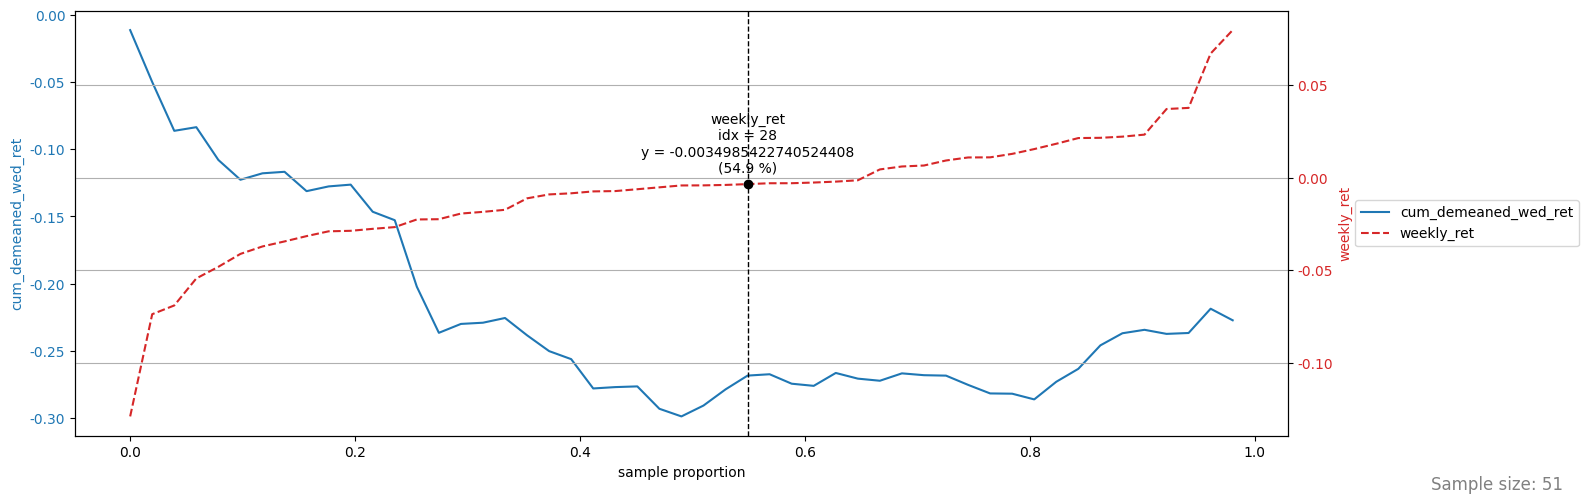

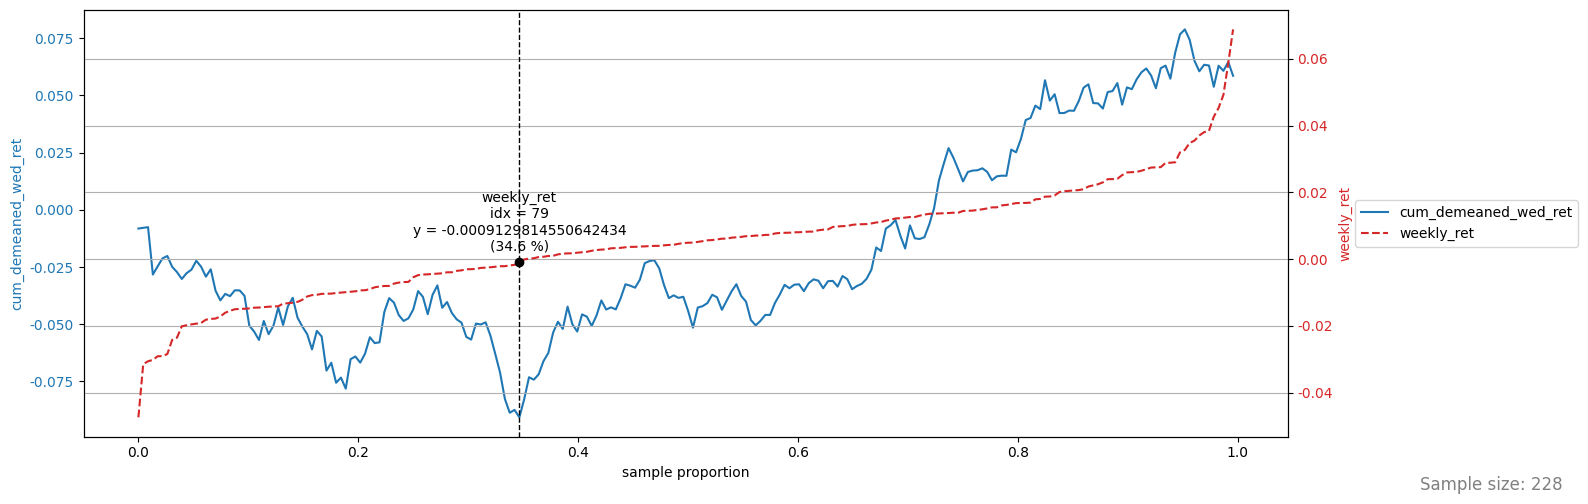

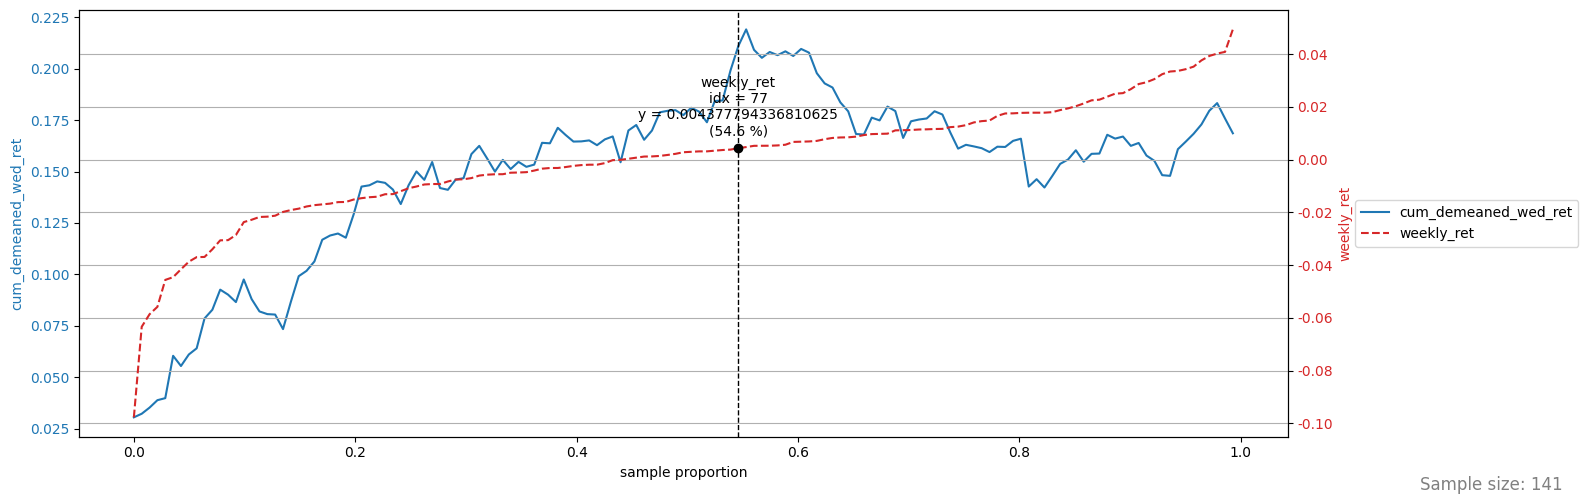

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': {'index': 77,
  'rank': 78,
  'proportion': 0.5460992907801419,
  'x': 0.5460992907801419,
  'y': 0.004377794336810625}}

In [1464]:
operate_df.set_index("index", inplace = True)

# t - 1 月 ret
first_open = temp_df.groupby("weekly_group")["Open"].first()
settle_open = temp_df.groupby("weekly_group")["Open"].last()
operate_df["weekly_ret"] = (settle_open / first_open) - 1

# sort by gap
operate_df = operate_df.sort_values("gap").reset_index(drop = False)

# seperate df by gap
left_df = operate_df[: 51].copy()
middle_df = operate_df[51: 279].copy()
right_df = operate_df[279: ].copy()

# sort by weekly_ret
left_df = left_df.sort_values("weekly_ret").reset_index(drop = True)
middle_df = middle_df.sort_values("weekly_ret").reset_index(drop = True)
right_df = right_df.sort_values("weekly_ret").reset_index(drop = True)

# cumsum
left_df["cum_demeaned_wed_ret"] = left_df["demeaned_wed_ret"].cumsum()
middle_df["cum_demeaned_wed_ret"] = middle_df["demeaned_wed_ret"].cumsum()
right_df["cum_demeaned_wed_ret"] = right_df["demeaned_wed_ret"].cumsum()

# plot
plot(left_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "weekly_ret", point_pct_ry = 0.55) # 0.55
plot(middle_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "weekly_ret", point_pct_ry = 0.35) # 0.35
plot(right_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "weekly_ret", point_pct_ry = 0.55) # 0.6

In [1465]:
"""seperate df & calculate mean"""
ll_df = left_df[: 28]
lr_df = left_df[28: ]
ml_df = middle_df[: 79]
mr_df = middle_df[79: ]
rl_df = right_df[: 90]
rr_df = right_df[90: ]

ll_mean = ll_df["demeaned_wed_ret"].mean()
lr_mean = lr_df["demeaned_wed_ret"].mean()
ml_mean = ml_df["demeaned_wed_ret"].mean()
mr_mean = mr_df["demeaned_wed_ret"].mean()
rl_mean = rl_df["demeaned_wed_ret"].mean()
rr_mean = rr_df["demeaned_wed_ret"].mean()
print(f"ll mean: {ll_mean:.6f}\nlr mean: {lr_mean:.6f}\nml mean: {ml_mean:.6f}\nmr mean: {mr_mean:.6f}\nrl mean: {rl_mean:.6f}\nrr mean: {rr_mean:.6f}")

ll mean: -0.009951
lr mean: 0.002235
ml mean: -0.001107
mr mean: 0.000980
rl mean: 0.002121
rr mean: -0.000436


In [1466]:
"""metric"""
# get_performance(ll_df, col = "demeaned_wed_ret")
# get_performance(lr_df, col = "demeaned_wed_ret")
get_performance(ml_df, col = "demeaned_wed_ret")
# get_performance(mr_df, col = "demeaned_wed_ret")
# get_performance(rl_df, col = "demeaned_wed_ret")
# get_performance(rr_df, col = "demeaned_wed_ret")

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,-8.51%,15.30%,-24.04%,1.33%,-2.07%,35,44,0,79,0.44%,-0.55%,-0.11%,100.00%,0.800,44.30%,-25.31%,-7.93%


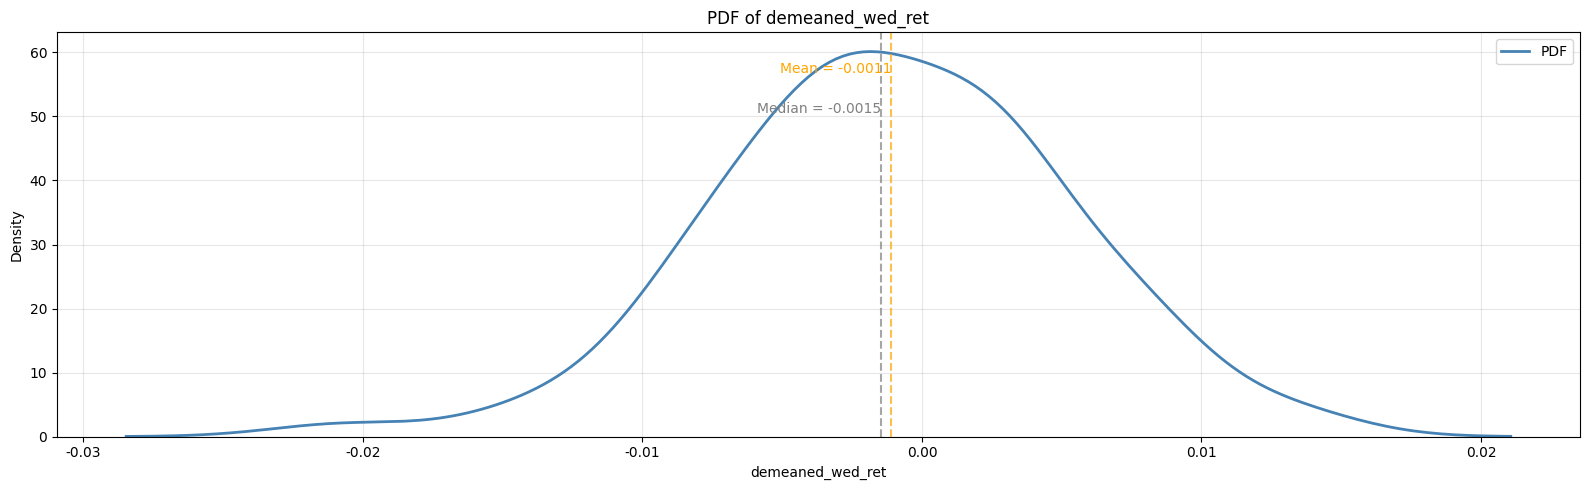

In [1467]:
"""plot pdf"""
# plot_pdf(ll_df, "demeaned_wed_ret")
# plot_pdf(lr_df, "demeaned_wed_ret")
plot_pdf(ml_df, "demeaned_wed_ret")
# plot_pdf(mr_df, "demeaned_wed_ret")
# plot_pdf(rl_df, "demeaned_wed_ret")
# plot_pdf(rr_df, "demeaned_wed_ret")

### backtest

In [1453]:
"""init backtesting df"""

backtest_df = TX_df.copy()
backtest_df.index = pd.to_datetime(TX_df.index)

# drop 掉 group 太少的資料
backtest_df = drop_small_groups(backtest_df, "weekly_group", 2)
temp_a_df = drop_small_groups(TXa_df, "weekly_group", 2)

# calculate gap
    # get idx
all_idx = backtest_df.index
all_idx = all_idx.delete(all_idx.get_loc("2018-07-11"))  # 夜盤沒有 2018-07-11 資料
target_idx = pd.to_datetime(temp_a_df["weekly_group"].unique())
pos = np.searchsorted(all_idx, target_idx)
prev_idx = all_idx[pos]

    # calculate gap
gap = (backtest_df.loc[target_idx, "Open"].to_numpy() / temp_a_df.loc[prev_idx, "Close"]) - 1
backtest_df.loc[target_idx, "gap"] = pd.Series(gap, index = target_idx)

# calculate thu_open ~ wed_open, log +
    # t - 1 週 ret
first_open = backtest_df.groupby("weekly_group")["Open"].first()
settle_open = backtest_df.groupby("weekly_group")["Open"].last()
weekly_ret = (settle_open / first_open) - 1
weekly_ret.index = pd.to_datetime(weekly_ret.index)
backtest_df.loc[weekly_ret.index, "weekly_ret"] = weekly_ret

# calculate wed ret
backtest_df.loc[target_idx, "wed_ret"] = (backtest_df.loc[target_idx, "Close"] / backtest_df.loc[target_idx, "Open"]) - 1
# backtest_df.loc[target_idx, "wed_ret"] = backtest_df.loc[target_idx, "wed_ret"] - 0.0001 # 扣 fee

# clean df
backtest_df.dropna(inplace = True)

In [1458]:
"""set condition"""
# 夜盤 gap
cond1 = backtest_df["gap"] <= -0.002143
cond2 = backtest_df["gap"] >= 0.000798

# thu_open ~ wed_open, log +
cond3 = backtest_df["weekly_ret"] <= -0.004183
cond4 = backtest_df["weekly_ret"] <= 0
cond5 = backtest_df["weekly_ret"] <= 0.006013

long_cond = (cond1 & ~cond3) | (~cond1 & ~cond2 & ~cond4) | (cond2 & cond5)
short_cond = (cond1 & cond3) | (~cond1 & ~cond2 & cond4) | (cond2 & ~cond5)

# long_cond = (cond1 & ~cond3) | (cond2 & cond5)
# short_cond = (cond1 & cond3) | (~cond1 & ~cond2 & cond4)

In [1459]:
# back test
backtest_df["ret"] = np.where(
    long_cond,
    backtest_df["wed_ret"],
    np.where(
        short_cond,
        - backtest_df["wed_ret"],
        0
    )
)

backtest_df["cum_ret"] = (1 + backtest_df["ret"]).cumprod() - 1

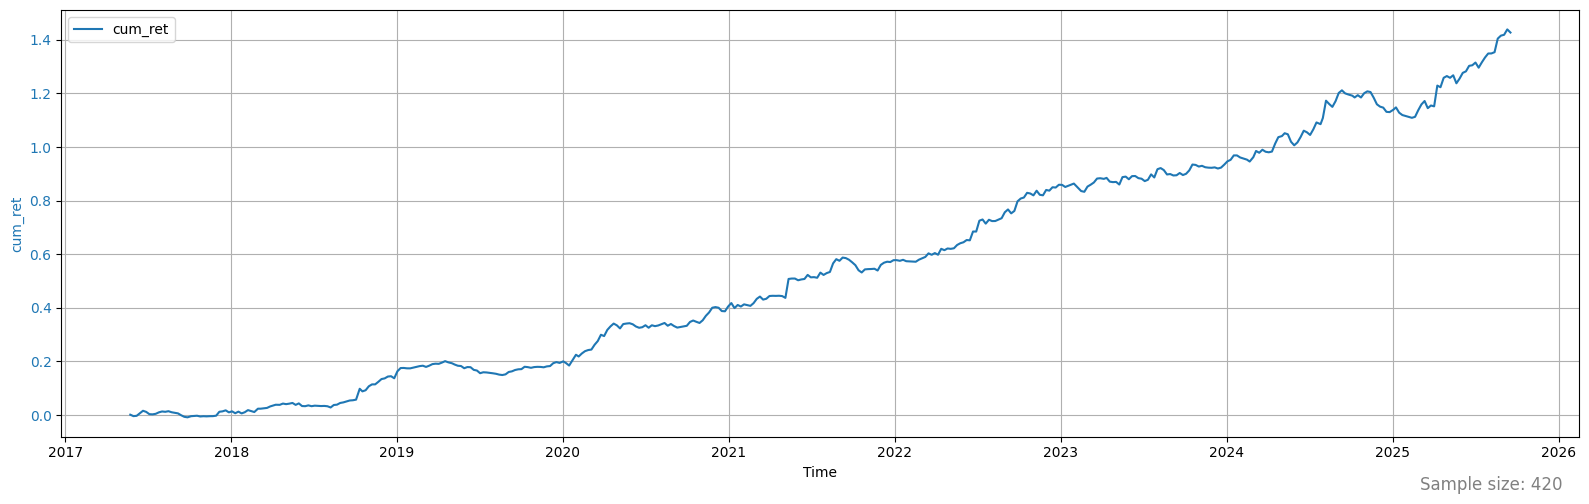

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,142.72%,159.15%,-69.22%,4.91%,-1.36%,246,170,4,420,0.65%,-0.41%,0.21%,99.05%,1.589,58.57%,32.50%,-4.64%


In [1460]:
plot(backtest_df, "cum_ret", "index")
performance = get_performance(backtest_df, "ret")
performance

## cum product daily ret

In [40]:
"""read data"""

main_df = TX_df.copy()


"""get indicator"""

main_df["indicator"] = np.nan

for g, sub in main_df.groupby("weekly_group"):
    # Sort by date (防止順序錯亂)
    sub = sub.sort_index()

    # 排除最後一天（結算日）不足兩筆時跳過
    if len(sub) < 2:
        continue

    sub_before = sub.iloc[:-1]

    # 累積報酬（連乘）
    cumprod = np.prod(1 + sub_before["daily_ret"].values) - 1

    # 只在每週最後一天填寫指標，避免整週重複值
    last_idx = sub.index[-1]
    main_df.loc[last_idx, "indicator"] = cumprod

main_df.dropna(subset = "indicator", inplace = True)


"""sort & get ret"""

main_df.sort_values("indicator", ignore_index = True, inplace = True)

mean = main_df["daily_ret"].mean()
main_df["demeaned_daily_ret"] = main_df["daily_ret"] - mean
main_df["cum_demeaned_daily_ret"] = main_df["demeaned_daily_ret"].cumsum()

In [42]:
plot(main_df, "cum_demeaned_daily_ret", ry = "indicator")

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

## sum 跳空 ret

In [ ]:
operate_df = pd.DataFrame()

temp_df = TX_df.copy()
temp_df["cross_daily_ret"] = (temp_df["Open"] / temp_df["Close"].shift(1)) - 1


# t - 1 週 ret sumation
operate_df["sum_cross_ret"] = temp_df.groupby("weekly_group")["cross_daily_ret"].sum()

# t 週結算日報酬
operate_df["wed_ret"] = (temp_df["Close"] / temp_df["Open"]) - 1

# fill wed_ret NaN 順延下一個交易日
nan_idx = operate_df[operate_df["wed_ret"].isna()].index
for t in nan_idx:
    next_idx = temp_df.index[temp_df.index > t]
    next_date = next_idx[0] if len(next_idx) > 0 else None
    next_date = pd.to_datetime(next_date, format = "%Y-%m-%d") if next_date is not None else None
    ret = (temp_df.loc[next_date, "Close"] / temp_df.loc[next_date, "Open"]) - 1 if next_date is not None else np.nan
    operate_df.loc[t, "wed_ret"] = ret


# demeaning
mean = operate_df["wed_ret"].mean()
operate_df["demeaned_wed_ret"] = operate_df["wed_ret"] - mean

In [65]:
"""sort & cumsum"""

operate_df.sort_values("sum_cross_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_wed_ret"] = operate_df["demeaned_wed_ret"].cumsum()

plot(operate_df, ly = "cum_demeaned_wed_ret", ry = "sum_cross_ret", point_pct_ly = 0.65)
# right idx: 344

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': {'index': 280,
  'rank': 281,
  'proportion': 0.6496519721577726,
  'x': 0.6496519721577726,
  'y': -0.06398847993116114},
 'point_ry': None}

In [492]:
"""seperate df & calculate mean"""
right_df = operate_df[344: ]
right_mean = right_df["demeaned_wed_ret"].mean()
print(f"right mean: {right_mean:.6f}")

right mean: 0.000657


## strategy backtest

In [ ]:
"""read data"""

# 2330 future
temp_df = CDF_df.copy()
temp_df["Close_t-1"] = temp_df["Close"].shift(1)
temp_df["gap"] = (temp_df["Open"] / temp_df["Close_t-1"]) - 1

# TX_df
main_df = TX_df.copy()
main_df.index = pd.to_datetime(main_df.index)
main_df["daily_ret"] = (main_df["Close"] / main_df["Open"]) - 1

# TXa_df
temp_a_df = TXa_df.copy()
temp_a_df.index = pd.to_datetime(temp_a_df.index)

main_df = drop_small_groups(main_df, "weekly_group", 2)

In [209]:
"""get indicator"""

# get filter 1
main_df["filter_1"] = temp_df["gap"]

# gap
    ## get intersection idx
all_idx = main_df.index.intersection(temp_a_df.index)
target_idx = [d for d in temp_a_df["weekly_group"].unique() if d in all_idx]
target_idx = pd.to_datetime(target_idx)

    ## calculate gap
gap = (main_df.loc[target_idx, "Open"].to_numpy() / temp_a_df.loc[target_idx, "Close"].to_numpy()) - 1
main_df["filter_3"] = pd.Series(gap, index = target_idx)

# factor
first_open = main_df.groupby("weekly_group")["Open"].first()
settle_open = main_df.groupby("weekly_group")["Open"].last()
factor = (settle_open / first_open) - 1
factor.index = pd.to_datetime(factor.index)
main_df["factor"] = factor

main_df.dropna(subset = "factor", inplace = True)
backtest_df = main_df.copy()

### factor + filter 1

In [ ]:
"""first sort"""
main_df = backtest_df.copy()

main_df.sort_values("factor", ignore_index = True, inplace = True)
main_df["cum_daily_ret"] = main_df["daily_ret"].cumsum()
mean = main_df["daily_ret"].mean()
main_df["demeaned_daily_ret"] = main_df["daily_ret"] - mean
main_df["cum_demeaned_daily_ret"] = main_df["demeaned_daily_ret"].cumsum()

# Find index where indicator is closest to zero
indicator_vals = main_df["factor"].to_numpy()
zero_idx = int(np.abs(indicator_vals).argmin())

# split
main_df_left = main_df.loc[: zero_idx + 1].copy()
main_df_right = main_df.loc[zero_idx + 1: ].copy()

plot(main_df_left, "cum_demeaned_daily_ret")
plot(main_df_right, "cum_demeaned_daily_ret")

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [230]:
"""second sort"""

for i in ["left", "right"]:
    vars()[f"main_df_{i}"].sort_values("filter_1", ignore_index = True, inplace = True)
    mean = vars()[f"main_df_{i}"]["daily_ret"].mean()
    vars()[f"main_df_{i}"]["demeaned_daily_ret"] = vars()[f"main_df_{i}"]["daily_ret"] - mean
    vars()[f"main_df_{i}"]["cum_demeaned)daily_ret"] = vars()[f"main_df_{i}"]["demeaned_daily_ret"].cumsum()
    vars()[f"main_df_{i}"]["cum_daily_ret"] = vars()[f"main_df_{i}"]["daily_ret"].cumsum()
    plot(vars()[f"main_df_{i}"], "cum_demeaned_daily_ret", ry = "filter_1")

In [231]:
main_df_ll = main_df_left.loc[: 73].copy()
main_df_lr = main_df_left.loc[73: ].copy()

test_ret(main_df_lr, "demeaned_daily_ret")
plot_scatter(main_df_lr, "filter_1", "demeaned_daily_ret")

Testing H0: mean(demeaned_daily_ret) = 0  vs  H1: mean(demeaned_daily_ret) != 0
n = 107
mean = 0.000066
std = 0.009625
std err = 0.000930
t-stat = 0.0712
p-value = 0.9433
confidence interval = (-0.001779, 0.001911)
reject null @ alpha = 0.05: False



### factor + filter 3

In [210]:
"""first sort"""
main_df = backtest_df.copy()

main_df.sort_values("factor", ignore_index = True, inplace = True)
mean = main_df["daily_ret"].mean()
main_df["demeaned_daily_ret"] = main_df["daily_ret"] - mean
main_df["cum_demeaned_daily_ret"] = main_df["demeaned_daily_ret"].cumsum()
plot(main_df, "cum_demeaned_daily_ret", ry = "factor", point_ry = 0)

# Find index where indicator is closest to zero
indicator_vals = main_df["factor"].to_numpy()
zero_idx = int(np.abs(indicator_vals).argmin())

# split
main_df_left = main_df.loc[: zero_idx + 1].copy()  # factor < 0
main_df_right = main_df.loc[zero_idx + 1: ].copy() # factor > 0

plot(main_df_left, "cum_demeaned_daily_ret", ry = "factor")
plot(main_df_right, "cum_demeaned_daily_ret", ry = "factor")

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [211]:
"""second sort"""

for i in ["left", "right"]:
    vars()[f"main_df_{i}"].sort_values("filter_3", ignore_index = True, inplace = True)

    mean = vars()[f"main_df_{i}"]["daily_ret"].mean()
    vars()[f"main_df_{i}"]["demeaned_daily_ret"] = vars()[f"main_df_{i}"]["daily_ret"] - mean
    vars()[f"main_df_{i}"]["cum_daily_ret"] = vars()[f"main_df_{i}"]["daily_ret"].cumsum()
    vars()[f"main_df_{i}"]["cum_demeaned_daily_ret"] = vars()[f"main_df_{i}"]["demeaned_daily_ret"].cumsum()

    plot(vars()[f"main_df_{i}"], "cum_demeaned_daily_ret", ry = "filter_3", point_pct_ry = 0.35)

# ll -> : 64 , lr -> 108:
main_df_ll = main_df_left.loc[: 46].copy()  # filter_3 < -0.00174487
main_df_lr = main_df_left.loc[108: ].copy() # filter_3 > 0.00061669

In [212]:
"""test"""

# 最後使用 main_df_lll(short)、main_df_lr(long)、main_df_rl(long)
main_df_ll["demeaned_daily_ret_reverse"] = - main_df_ll["demeaned_daily_ret"]
perform_ll = get_performance(main_df_ll, "demeaned_daily_ret_reverse")
perform_lr = get_performance(main_df_lr, "demeaned_daily_ret")
perform_right = get_performance(main_df_right, "demeaned_daily_ret")

test_ret(main_df_ll, "demeaned_daily_ret", alternative = "less")
test_ret(main_df_lr, "demeaned_daily_ret", alternative = "greater")
test_ret(main_df_right, "demeaned_daily_ret", alternative = "greater")

Testing H0: mean(demeaned_daily_ret) = 0  vs  H1: mean(demeaned_daily_ret) < 0
n = 47
mean = -0.005583
std = 0.013255
std err = 0.001933
t-stat = -2.8876
p-value = 0.002949
confidence interval = (-inf, -0.002337)
reject null @ alpha = 0.05: True

Testing H0: mean(demeaned_daily_ret) = 0  vs  H1: mean(demeaned_daily_ret) > 0
n = 72
mean = 0.003167
std = 0.007504
std err = 0.000884
t-stat = 3.5810
p-value = 0.0003114
confidence interval = (0.001693, inf)
reject null @ alpha = 0.05: True

Testing H0: mean(demeaned_daily_ret) = 0  vs  H1: mean(demeaned_daily_ret) > 0
n = 242
mean = -0.000000
std = 0.005826
std err = 0.000375
t-stat = -0.0000
p-value = 0.5
confidence interval = (-0.000618, inf)
reject null @ alpha = 0.05: False



In [213]:
perform_ll

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,29.40%,35.91%,-9.67%,4.84%,-1.31%,28,19,0,47,1.28%,-0.51%,0.56%,100.00%,2.520,59.57%,43.53%,-2.38%


In [214]:
perform_lr

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,25.31%,33.24%,-10.44%,3.15%,-1.16%,48,24,0,72,0.69%,-0.43%,0.32%,100.00%,1.592,66.67%,45.73%,-1.78%


In [215]:
perform_right

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,-0.41%,54.20%,-54.20%,1.72%,-2.41%,118,124,0,242,0.46%,-0.44%,-0.00%,100.00%,1.051,48.76%,-0.00%,-8.27%


In [224]:
"""overall"""

# set conditions
    ## factor
cond1 = backtest_df["factor"] < 0
    ## filter
cond2 = backtest_df["filter_3"] < -0.00174487 # l
cond3 = backtest_df["filter_3"] < 0.00061669  # l
    ## LS
long_cond = (cond1 & ~cond3)
long_cond = (cond1 & ~cond3) | (~cond1)
short_cond = (cond1 & cond2)

# backtest
backtest_df["ret"] = np.where(
    long_cond,
    backtest_df["daily_ret"] - 0.0001,
    np.where(
        short_cond,
        (- backtest_df["daily_ret"]) - 0.0001,
        0
    )
)

backtest_df["cum_ret"] = backtest_df["ret"].cumsum()

In [223]:
"""不加沒用的 main_df_right"""
perform = get_performance_effective(backtest_df, "ret")
plot(backtest_df, "cum_ret")
perform

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,總次(含0),勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,56.40%,66.43%,-21.01%,4.90%,-1.25%,73,46,302,119,421,0.91%,-0.46%,0.38%,28.27%,1.993,61.34%,41.94%,-2.90%


In [225]:
"""加上沒用的 main_df_right"""
perform = get_performance_effective(backtest_df, "ret")
plot(backtest_df, "cum_ret")
perform

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,總次(含0),勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,100.83%,134.15%,-63.30%,4.90%,-2.31%,215,146,60,361,421,0.62%,-0.43%,0.20%,85.75%,1.439,59.56%,31.45%,-3.56%


### filter 3 + factor

In [183]:
"""first sort"""
main_df = backtest_df.copy()

main_df.sort_values("filter_3", ignore_index = True, inplace = True)
mean = main_df["daily_ret"].mean()
main_df["demeaned_daily_ret"] = main_df["daily_ret"] - mean
main_df["cum_demeaned_daily_ret"] = main_df["demeaned_daily_ret"].cumsum()
plot(main_df, "cum_demeaned_daily_ret", ry = "filter_3")

main_df_left = main_df.loc[: 127].copy()
main_df_right = main_df.loc[127: ].copy()

In [ ]:
"""second sort"""


for i in ["left", "right"]:
    vars()[f"main_df_{i}"].sort_values("factor", ignore_index = True, inplace = True)
    mean = vars()[f"main_df_{i}"]["daily_ret"].mean()
    vars()[f"main_df_{i}"]["demeaned_daily_ret"] = vars()[f"main_df_{i}"]["daily_ret"] - mean
    vars()[f"main_df_{i}"]["cum_demeaned_daily_ret"] = vars()[f"main_df_{i}"]["demeaned_daily_ret"].cumsum()
    vars()[f"main_df_{i}"]["cum_daily_ret"] = vars()[f"main_df_{i}"]["daily_ret"].cumsum()
    plot(vars()[f"main_df_{i}"], "cum_demeaned_daily_ret", ry = "factor", point_pct_ry = 0.4)

main_df_ll = main_df_left.loc[: 52]
main_df_lr = main_df_left.loc[52: ]

In [184]:
test_ret(main_df_ll, "demeaned_daily_ret")
test_ret(main_df_lr, "demeaned_daily_ret")
test_ret(main_df_right, "demeaned_daily_ret")

Testing H0: mean(demeaned_daily_ret) = 0  vs  H1: mean(demeaned_daily_ret) != 0
n = 47
mean = -0.005581
std = 0.013255
std err = 0.001933
t-stat = -2.8868
p-value = 0.005911
confidence interval = (-0.009473, -0.001690)
reject null @ alpha = 0.05: True

Testing H0: mean(demeaned_daily_ret) = 0  vs  H1: mean(demeaned_daily_ret) != 0
n = 75
mean = 0.003249
std = 0.007310
std err = 0.000844
t-stat = 3.8487
p-value = 0.0002499
confidence interval = (0.001567, 0.004930)
reject null @ alpha = 0.05: True

Testing H0: mean(demeaned_daily_ret) = 0  vs  H1: mean(demeaned_daily_ret) != 0
n = 304
mean = 0.000845
std = 0.006293
std err = 0.000361
t-stat = 2.3410
p-value = 0.01988
confidence interval = (0.000135, 0.001555)
reject null @ alpha = 0.05: True



In [203]:
"""overall"""

# set conditions
    ## filter 3
cond1 = backtest_df["filter_3"] < 0
    ## factor
cond2 = backtest_df["factor"] < 0
    ## LS
long_cond = (cond1 & ~cond2)
long_cond = (cond1 & ~cond2) | ~cond1
short_cond = (cond1 & cond2)

# backtest
backtest_df["ret"] = np.where(
    long_cond,
    backtest_df["daily_ret"] - 0.0001,
    np.where(
        short_cond,
        (- backtest_df["daily_ret"]) - 0.0001,
        0
    )
)

backtest_df["cum_ret"] = backtest_df["ret"].cumsum()

In [202]:
"""不加沒用的 main_df_right"""
perform = get_performance_effective(backtest_df, "ret")
plot(backtest_df, "cum_ret")
perform

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,總次(含0),勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,56.81%,66.70%,-21.01%,4.90%,-1.25%,75,46,310,121,431,0.89%,-0.46%,0.38%,28.07%,1.947,61.98%,42.46%,-2.90%


In [204]:
"""加上沒用的 main_df_right"""
perform = get_performance_effective(backtest_df, "ret")
plot(backtest_df, "cum_ret")
perform

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,總次(含0),勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,84.13%,146.77%,-84.47%,4.90%,-2.31%,247,184,0,431,431,0.59%,-0.46%,0.14%,100.00%,1.294,57.31%,24.33%,-3.92%


# 月結算 target: wed

## read

In [13]:
TX_df = pd.read_csv("TX.csv", index_col = "Timestamp")
TX_df.index = pd.to_datetime(TX_df.index, format = "%Y-%m-%d")

## thu_open ~ wed_open log +

In [56]:
main_df = TX_df.copy()

# ret
first_open = main_df.groupby("monthly_group")["Open"].first()
settle_open = main_df.groupby("monthly_group")["Open"].last()
monthly_ret = (settle_open / first_open) - 1
monthly_ret.index = pd.to_datetime(monthly_ret.index)
main_df["indicator"] = monthly_ret
main_df["daily_ret"] = (main_df["Close"] / main_df["Open"]) - 1

# split df
main_df.dropna(subset = "indicator", inplace = True)

# demeaning
mean = main_df["daily_ret"].mean()
main_df["demeaned_daily_ret"] = main_df["daily_ret"] - mean

In [ ]:
"""sort & cumsum & plot"""

main_df.sort_values("indicator", ignore_index = True, inplace = True)
main_df["cum_demeaned_daily_ret"] = main_df["demeaned_daily_ret"].cumsum()

plot(main_df, x = "index", ly = "cum_demeaned_daily_ret", ry = "indicator")

x = main_df["indicator"].to_numpy()
y = main_df["cum_demeaned_daily_ret"].to_numpy()
slope, intercept, r, p, stderr = linregress(x, y)
mean = main_df["demeaned_daily_ret"].mean()
print(f"    left -> mean: {mean:.6f} / slope: {slope:.6f} / p_value: {p:.6f}")
fig = plot_scatter(main_df, "indicator", "cum_demeaned_daily_ret")
fig.show()

    left -> mean: 0.000000 / slope: 0.125893 / p_value: 0.000000


# 週結算 target: thu

## read

In [226]:
TX_df = pd.read_csv("TX.csv", index_col = "Timestamp")
TX_df.index = pd.to_datetime(TX_df.index, format = "%Y-%m-%d")

## sum t - 1 週 ret, target: thu ret

In [227]:
operate_df = pd.DataFrame()

# 算 ret
temp_df = TX_df.copy()
temp_df["daily_ret"] = (temp_df["Close"] / temp_df["Open"]) - 1

# t - 1 週報酬
operate_df["sum_ret"] = temp_df.groupby("weekly_group")["daily_ret"].sum().rename("sum_ret")
operate_df = operate_df[: -1]
operate_df.index = pd.to_datetime(operate_df.index, format = "%Y-%m-%d")

# get thu index
all_date = temp_df.index
settle_date = list(temp_df["weekly_group"].unique())
target_pos = all_date.searchsorted(settle_date, side = "right")
target_pos = target_pos[: -1]

# t 週第一跟根報酬
thu_ret = (temp_df["Close"].iloc[target_pos] / temp_df["Open"].iloc[target_pos]) - 1
operate_df["thu_ret"] = thu_ret.values

# demeaning
mean = operate_df["thu_ret"].mean()
operate_df["demeaned_thu_ret"] = operate_df["thu_ret"] - mean
operate_df

,sum_ret,thu_ret,demeaned_thu_ret
weekly_group,,,
2017-05-17,-0.001092,0.004847,0.005043
2017-05-24,0.004540,0.006473,0.006669
2017-05-31,-0.002534,0.003888,0.004084
2017-06-07,0.012273,0.000686,0.000882
2017-06-14,-0.011982,0.002189,0.002385
...,...,...,...
2025-08-13,0.017422,-0.003575,-0.003379
2025-08-20,-0.016003,0.005184,0.005379
2025-08-27,0.014493,-0.005337,-0.005141


In [229]:
"""sort, cumsum & plot"""
operate_df.sort_values("sum_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_thu_ret"] = operate_df["demeaned_thu_ret"].cumsum()

plot(operate_df, x = "index", ly = "cum_demeaned_thu_ret", ry = "sum_ret")

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [1257]:
a = operate_df.loc[214: 343].copy()
mean_a = a["demeaned_thu_ret"].mean()
print(mean_a)

-0.0010371785997030267


## sum 跳空

In [1264]:
operate_df = pd.DataFrame()

temp_df = TX_df.copy()
temp_df["cross_daily_ret"] = (temp_df["Open"].shift(-1) / temp_df["Close"]) - 1

# t - 1 週 ret sumation
operate_df["sum_cross_ret"] = temp_df.groupby("weekly_group")["cross_daily_ret"].sum()
operate_df = operate_df[: -1]

# 抓到結算隔天的idx
all_date = temp_df.index
settle_date = list(temp_df["weekly_group"].unique())
target_pos = all_date.searchsorted(settle_date, side = "right")
target_pos = target_pos[: -1]

# get target ret
thu_ret = (temp_df["Close"].iloc[target_pos] / temp_df["Open"].iloc[target_pos]) - 1
operate_df["thu_ret"] = thu_ret.values

# demeaning
mean = operate_df["thu_ret"].mean()
operate_df["demeaned_thu_ret"] = operate_df["thu_ret"] - mean
operate_df

,sum_cross_ret,thu_ret,demeaned_thu_ret
weekly_group,,,
2017-05-17,-0.012594,0.004847,0.005043
2017-05-24,0.009430,0.006473,0.006669
2017-05-31,0.001383,0.003888,0.004084
2017-06-07,0.004962,0.000686,0.000882
2017-06-14,-0.003048,0.002189,0.002385
...,...,...,...
2025-08-13,0.010973,-0.003575,-0.003379
2025-08-20,-0.008960,0.005184,0.005379
2025-08-27,0.011881,-0.005337,-0.005141


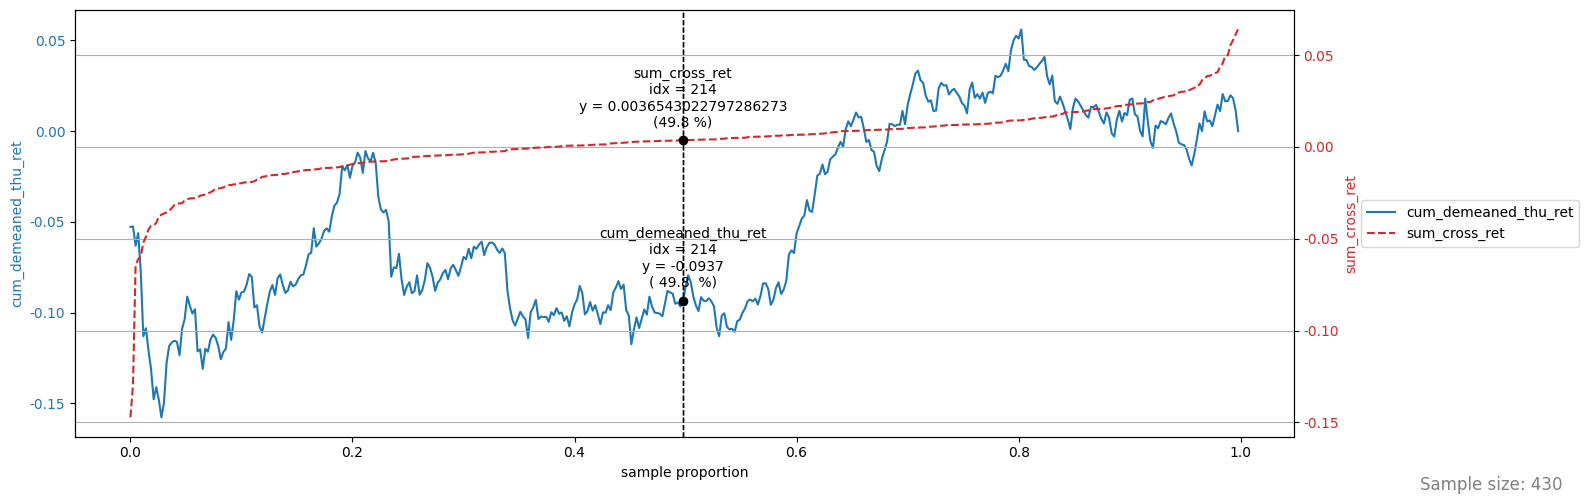

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': {'index': 214,
  'rank': 215,
  'proportion': 0.49767441860465117,
  'x': 0.49767441860465117,
  'y': -0.09369325378200191},
 'point_ry': {'index': 214,
  'rank': 215,
  'proportion': 0.49767441860465117,
  'x': 0.49767441860465117,
  'y': 0.0036543022797286273}}

In [1266]:
"""sort & cumsum & plot"""

operate_df.sort_values("sum_cross_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_thu_ret"] = operate_df["demeaned_thu_ret"].cumsum()

plot(operate_df, x = "index", ly = "cum_demeaned_thu_ret", ry = "sum_cross_ret", point_pct_ly = 0.5, point_pct_ry = 0.5)

In [1268]:
a = operate_df.loc[214: 343]
mean_a = a["demeaned_thu_ret"].mean()
print(mean_a)

0.0011476839451504495


# Others

## read

In [154]:
TX_df = pd.read_csv("TX.csv", index_col = "Timestamp")
TX_df.index = pd.to_datetime(TX_df.index)

## 週、月傾向

In [ ]:
backtest_df = TX_df.copy()

# indicator
    ## weekly
first_open = backtest_df.groupby("weekly_group")["Open"].first()
settle_open = backtest_df.groupby("weekly_group")["Open"].last()
indicator = (settle_open / first_open) - 1
indicator.index = pd.to_datetime(indicator.index)
backtest_df["weekly_indicator"] = indicator

    ## monthly
first_open = backtest_df.groupby("monthly_group")["Open"].first()
settle_open = backtest_df.groupby("monthly_group")["Open"].last()
indicator = (settle_open / first_open) - 1
indicator.index = pd.to_datetime(indicator.index)
backtest_df["monthly_indicator"] = indicator

# seperate df & get ret
    ## weekly
w_backtest_df = backtest_df.dropna(subset = "weekly_indicator").copy()
w_backtest_df["wed_ret"] = (w_backtest_df["Close"] / w_backtest_df["Open"]) - 1
mean = w_backtest_df["wed_ret"].mean()
w_backtest_df["demeaned_wed_ret"] = w_backtest_df["wed_ret"] - mean

    ## monthly
m_backtest_df = backtest_df.dropna(subset = "monthly_indicator").copy()
m_backtest_df["wed_ret"] = (m_backtest_df["Close"] / m_backtest_df["Open"]) - 1
mean = m_backtest_df["wed_ret"].mean()
m_backtest_df["demeaned_wed_ret"] = m_backtest_df["wed_ret"] - mean

In [157]:
"""calculate mean & plot"""

# sort
w_backtest_df.sort_values("weekly_indicator", ignore_index = True, inplace = True)
m_backtest_df.sort_values("monthly_indicator", ignore_index = True, inplace = True)

# cumsum
w_backtest_df["cum_demeaned_wed_ret"] = w_backtest_df["demeaned_wed_ret"].cumsum()
m_backtest_df["cum_demeaned_wed_ret"] = m_backtest_df["demeaned_wed_ret"].cumsum()

# calculate mean
w_mean = w_backtest_df["demeaned_wed_ret"].mean()
m_mean = m_backtest_df["demeaned_wed_ret"].mean()

test_ret(w_backtest_df, "demeaned_wed_ret")
test_ret(m_backtest_df, "demeaned_wed_ret")
plot(w_backtest_df, "cum_demeaned_wed_ret", ry = "weekly_indicator")
plot(m_backtest_df, "cum_demeaned_wed_ret", ry = "monthly_indicator")

Testing H0: mean(demeaned_wed_ret) = 0  vs  H1: mean(demeaned_wed_ret) != 0
n = 431
mean = 0.000000
std = 0.007690
std err = 0.000370
t-stat = 0.0000
p-value = 1
confidence interval = (-0.000728, 0.000728)
reject null @ alpha = 0.05: False

Testing H0: mean(demeaned_wed_ret) = 0  vs  H1: mean(demeaned_wed_ret) != 0
n = 101
mean = 0.000000
std = 0.007175
std err = 0.000714
t-stat = 0.0000
p-value = 1
confidence interval = (-0.001416, 0.001416)
reject null @ alpha = 0.05: False



{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [165]:
from scipy import stats

def compare_returns(fut, twii, method="welch", alternative="greater"):
    """test fut > twii"""
    fut = pd.Series(fut).dropna()
    twii = pd.Series(twii).dropna()
    
    if method == "welch":
        t_stat, p_value = stats.ttest_ind(fut, twii, equal_var=False, alternative=alternative)
        test_name = "Welch's t-test"
    elif method == "student":
        t_stat, p_value = stats.ttest_ind(fut, twii, equal_var=True, alternative=alternative)
        test_name = "Student's t-test"
    elif method == "mannwhitney":
        t_stat, p_value = stats.mannwhitneyu(fut, twii, alternative=alternative)
        test_name = "Mann–Whitney U"
    else:
        raise ValueError("method must be 'welch', 'student', or 'mannwhitney'")

    print(f"{test_name}: t = {t_stat:.4f}, p = {p_value:.4g}, alternative = {alternative}")
    return t_stat, p_value

compare_returns(m_backtest_df["demeaned_wed_ret"], w_backtest_df["demeaned_wed_ret"])

Welch's t-test: t = -0.0000, p = 0.5, alternative = greater


(np.float64(-3.735891385464732e-17), np.float64(0.5))

In [167]:
res = test_volatility_between_frames(m_backtest_df, w_backtest_df, value_col="demeaned_wed_ret")
print(res)

method                       levene
n_high                          101
n_low                           431
std_high                   0.007175
std_low                     0.00769
variance_ratio_high_low    0.870581
std_ratio_high_low         0.933049
statistic                  0.367006
p_value                      0.5449
higher_vol_group             low_df
significant_at_5pct           False
dtype: object


In [150]:
"""extract df to indicator > 0"""

# extract
extract_w_backtest_df_left, extract_w_backtest_df_right = w_backtest_df.loc[w_backtest_df["weekly_indicator"] <= 0].copy(), w_backtest_df.loc[w_backtest_df["weekly_indicator"] > 0].copy()
extract_m_backtest_df_left, extract_m_backtest_df_right = m_backtest_df.loc[m_backtest_df["monthly_indicator"] <= 0].copy(), m_backtest_df.loc[m_backtest_df["monthly_indicator"] > 0].copy()

# calculate mean
w_mean_left, w_mean_right = extract_w_backtest_df_left["demeaned_wed_ret"].mean(), extract_w_backtest_df_right["demeaned_wed_ret"].mean()
m_mean_left, m_mean_right = extract_m_backtest_df_left["demeaned_wed_ret"].mean(), extract_m_backtest_df_right["demeaned_wed_ret"].mean()

# recumsum wed_ret
extract_w_backtest_df_left["cum_demeaned_wed_ret"], extract_w_backtest_df_right["cum_demeaned_wed_ret"] = extract_w_backtest_df_left["demeaned_wed_ret"].cumsum(), extract_w_backtest_df_right["demeaned_wed_ret"].cumsum()
extract_m_backtest_df_left["cum_demeaned_wed_ret"], extract_m_backtest_df_right["cum_demeaned_wed_ret"] = extract_m_backtest_df_left["demeaned_wed_ret"].cumsum(), extract_m_backtest_df_right["demeaned_wed_ret"].cumsum()

plot(extract_w_backtest_df_left, "cum_demeaned_wed_ret", ry = "weekly_indicator")
plot(extract_w_backtest_df_right, "cum_demeaned_wed_ret", ry = "weekly_indicator")
plot(extract_m_backtest_df_left, "cum_demeaned_wed_ret", ry = "monthly_indicator")
plot(extract_m_backtest_df_right, "cum_demeaned_wed_ret", ry = "monthly_indicator")

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [151]:
plot_scatter(extract_w_backtest_df_left, "weekly_indicator", "demeaned_wed_ret")
plot_scatter(extract_w_backtest_df_right, "weekly_indicator", "demeaned_wed_ret")
plot_scatter(extract_m_backtest_df_left, "monthly_indicator", "demeaned_wed_ret")
plot_scatter(extract_m_backtest_df_right, "monthly_indicator", "demeaned_wed_ret")

In [79]:
plot_pdf(extract_w_backtest_df_left, "demeaned_wed_ret")
plot_pdf(extract_w_backtest_df_right, "demeaned_wed_ret")

In [ ]:
test_ret(extract_w_backtest_df_left, "demeaned_wed_ret")
test_ret(extract_w_backtest_df_right, "demeaned_wed_ret")
test_ret(extract_m_backtest_df_left, "demeaned_wed_ret")
test_ret(extract_m_backtest_df_right, "demeaned_wed_ret")


Testing H0: mean(demeaned_wed_ret) = 0  vs  H1: mean(demeaned_wed_ret) != 0
n = 184
mean = -0.001098
std = 0.009573
std err = 0.000706
t-stat = -1.5564
p-value = 0.1213
confidence interval = (-0.002491, 0.000294)
reject null @ alpha = 0.05: False

Testing H0: mean(demeaned_wed_ret) = 0  vs  H1: mean(demeaned_wed_ret) != 0
n = 247
mean = 0.000818
std = 0.005797
std err = 0.000369
t-stat = 2.2186
p-value = 0.02743
confidence interval = (0.000092, 0.001545)
reject null @ alpha = 0.05: True

Testing H0: mean(demeaned_wed_ret) = 0  vs  H1: mean(demeaned_wed_ret) != 0
n = 38
mean = 0.000046
std = 0.007726
std err = 0.001253
t-stat = 0.0365
p-value = 0.9711
confidence interval = (-0.002494, 0.002585)
reject null @ alpha = 0.05: False

Testing H0: mean(demeaned_wed_ret) = 0  vs  H1: mean(demeaned_wed_ret) != 0
n = 63
mean = -0.000028
std = 0.006885
std err = 0.000867
t-stat = -0.0318
p-value = 0.9748
confidence interval = (-0.001762, 0.001706)
reject null @ alpha = 0.05: False



## basic indicator time trend

### read

In [138]:
main_df = TX_df.copy()

main_df["daily_ret"] = (main_df["Close"] / main_df["Open"]) - 1

# make indicator
first_open = main_df.groupby("weekly_group")["Open"].first()
settle_open = main_df.groupby("weekly_group")["Open"].last()
indicator = (settle_open / first_open) - 1
indicator.index = pd.to_datetime(indicator.index)
main_df["indicator"] = indicator

main_df["ret"] = np.where(
    main_df["indicator"] < 0,
    - main_df["daily_ret"],
    np.where(
        main_df["indicator"] >= 0,
        main_df["daily_ret"],
        0
    )
)
main_df["cum_ret"] = main_df["ret"].cumsum()

main_df.dropna(subset = "indicator", inplace = True)
main_df.reset_index(inplace = True)
main_df.reset_index(inplace = True)

In [149]:
plot_sequence(main_df, "ret")

In [150]:
test_ret(main_df, "ret")
plot_scatter(main_df, "index", "ret")

Testing H0: mean(ret) = 0  vs  H1: mean(ret) != 0
n = 431
mean = 0.000995
std = 0.007633
std err = 0.000368
t-stat = 2.7075
p-value = 0.00705
confidence interval = (0.000273, 0.001718)
reject null @ alpha = 0.05: True



## 台指期日報酬pdf

### read

In [1415]:
TX_df = pd.read_csv("TX.csv")
TX_df.set_index("Timestamp", inplace = True)
TX_df.index = pd.to_datetime(TX_df.index)

TXa_df = pd.read_csv("TX_after.csv")
TXa_df.set_index("Timestamp", inplace = True)
TXa_df.index = pd.to_datetime(TXa_df.index)

### draw pdf

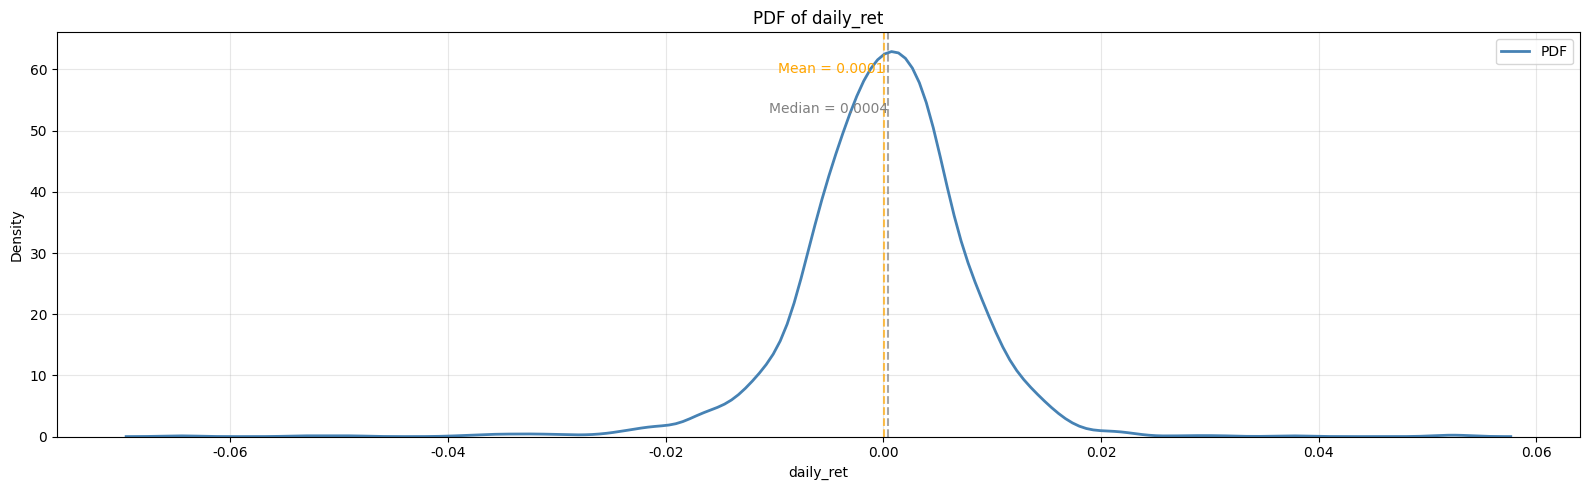

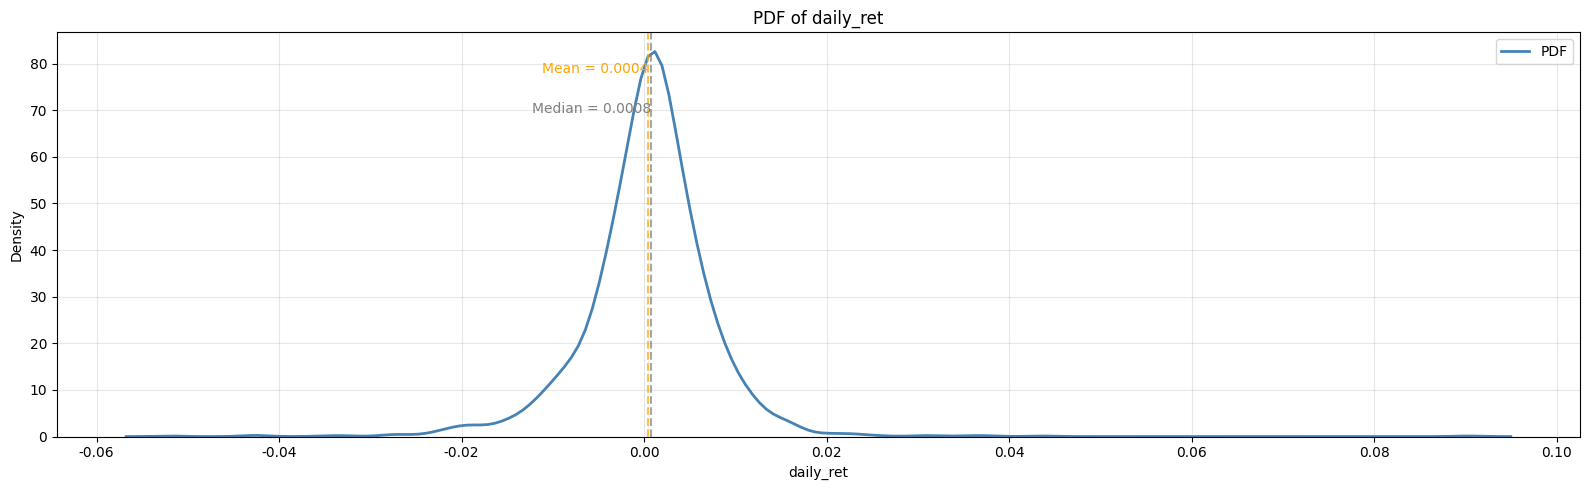

In [1416]:
TX_df["daily_ret"] = (TX_df["Close"] / TX_df["Open"]) - 1
TXa_df["daily_ret"] = (TXa_df["Close"] / TXa_df["Open"]) - 1
plot_pdf(TX_df, "daily_ret")
plot_pdf(TXa_df, "daily_ret")

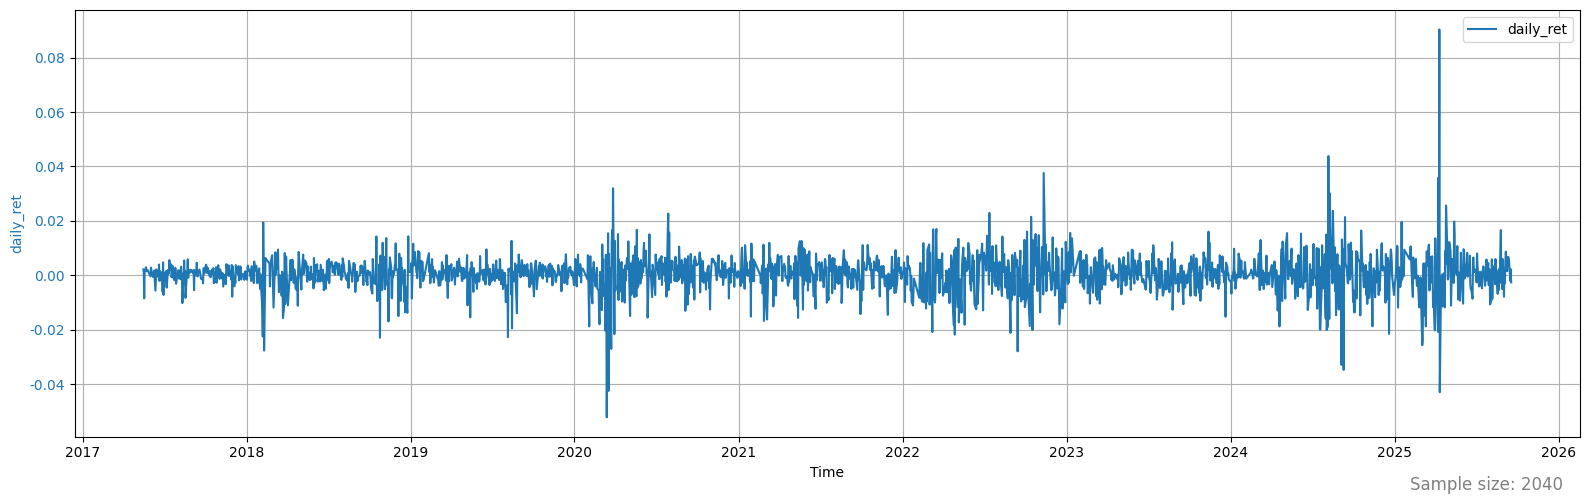

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [1469]:
plot(TXa_df, "daily_ret", "index")